In [1]:
import sys
sys.path.append('..')

In [2]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

import shapely
from shapely import Polygon
from simplification.cutil import simplify_coords_vw

from detect_ceiling import detect_ceiling_peaks, extract_ceiling_levels, refine_all_ceiling_levels
from sklearn.model_selection import ParameterGrid
from get_dimentions import *
from get_boundary import *
from detect_floor import *
from detect_walls import *
from finetune import *

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
FILE = "../data/alex1.ply"

In [4]:
with open('../config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
s_val = PointCloudDataset(FILE)

In [6]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

In [7]:
# sem_seg.visualize_pcd()

In [8]:
# sem_seg.ransac_segment()

In [9]:
# sem_seg.ransac_segmentor.visualize_segments()

In [10]:
points = sem_seg.points[:, :3]

### BY CEILING


DETECT CEILING PEAKS
Found 3 peaks

Top 10 peaks by height:
ID    Height (m)   Points       Type           
──────────────────────────────────────────────────
0     1.125        4,514        CEILING ✓      
1     0.625        2,232        CEILING ✓      
2     -1.815       19,806       FLOOR          


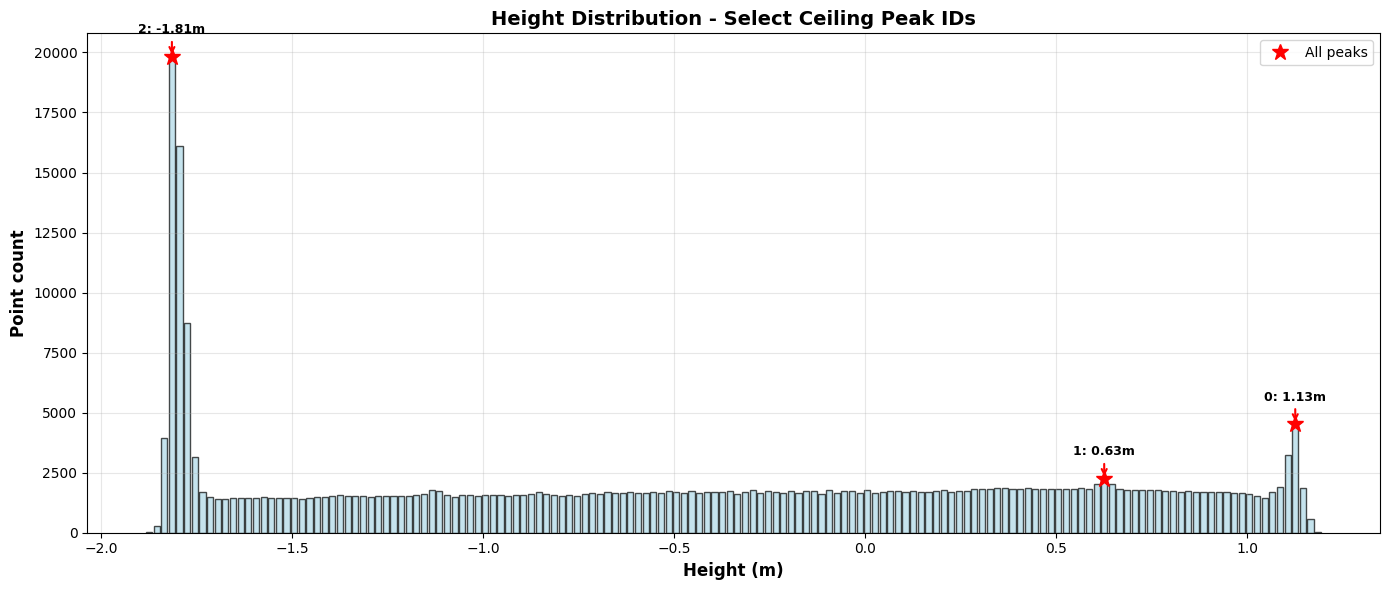


✓ Inspect the plot and choose ceiling peak IDs
  Example: If peaks 0 and 1 are ceilings, use: [0, 1]


In [11]:
step1_result = detect_ceiling_peaks(points, show_top_n=10)


EXTRACT CEILING LEVELS
✓ Ceiling level 0: 1.125m with 16,095 points
✓ Ceiling level 1: 0.625m with 19,044 points


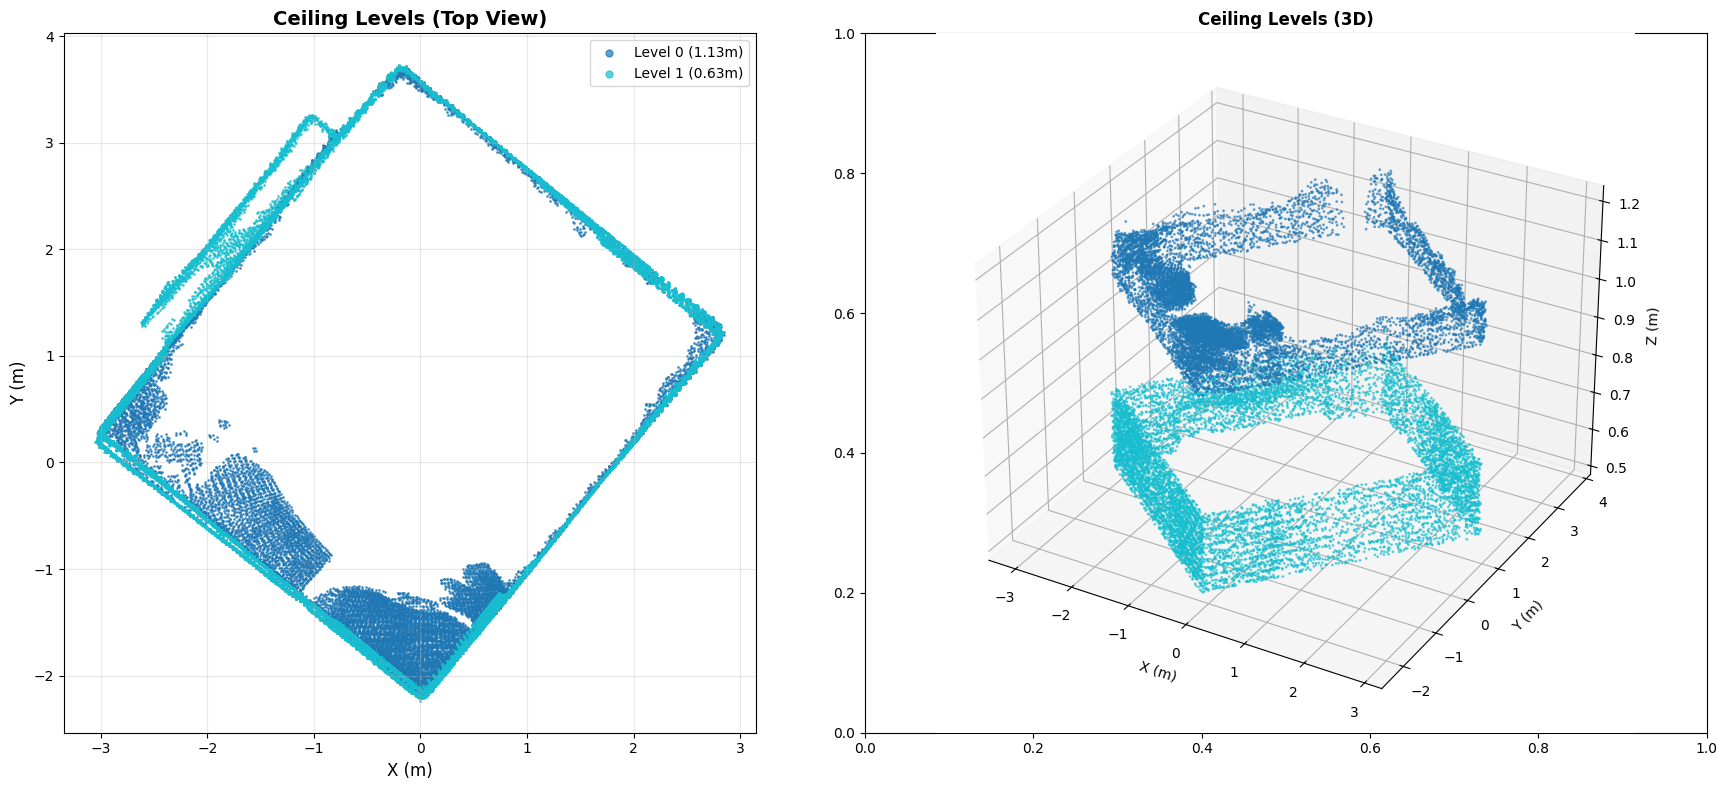


✓ Extracted 2 ceiling level(s)


In [12]:
ceiling_levels = extract_ceiling_levels(
    step1_result,
    selected_peak_ids=[0, 1],
    thickness=0.10
)

In [13]:
all_ceiling_points = np.vstack([i["points"] for i in ceiling_levels])

In [14]:
ceiling_points_2d = all_ceiling_points[:, :2]

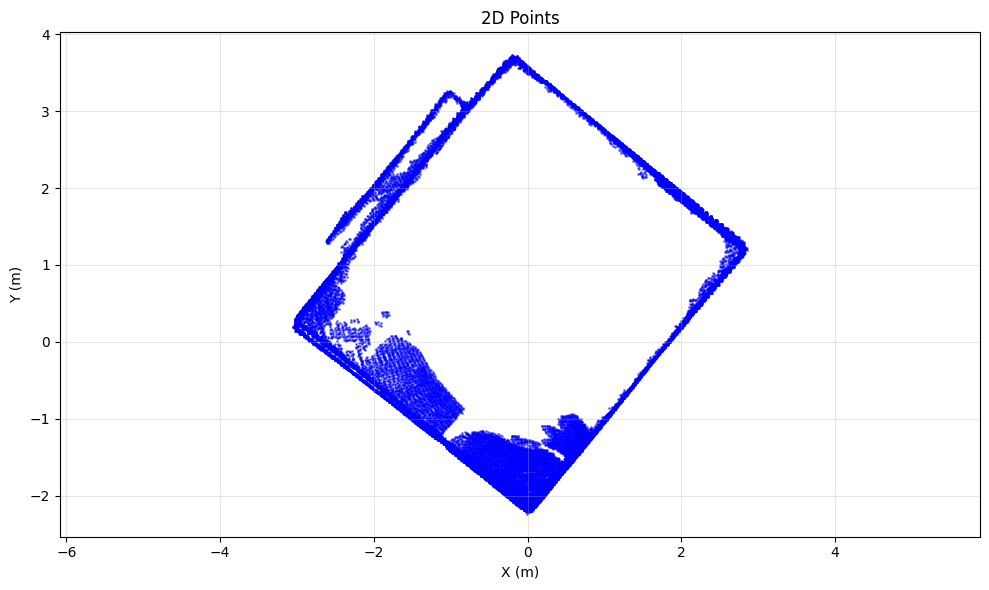

In [15]:
visualize_2d_points(ceiling_points_2d, downsample=1)

In [16]:
refined_ceiling_levels = refine_all_ceiling_levels(
    ceiling_levels,
    distance_threshold=0.1
)


REFINING ALL CEILING LEVELS

--- Level 0 (Height: 1.125m) ---

RANSAC PLANE REFINEMENT
Input points: 16,095
Distance threshold: 0.1m

✓ Plane equation: 0.0022x + 0.0060y + 1.0000z + -1.0995 = 0
✓ Inliers: 16,005 / 16,095 (99.4%)
✓ Outliers removed: 90 (0.6%)

--- Level 1 (Height: 0.625m) ---

RANSAC PLANE REFINEMENT
Input points: 19,044
Distance threshold: 0.1m

✓ Plane equation: 0.0046x + 0.0025y + 1.0000z + -0.6187 = 0
✓ Inliers: 17,443 / 19,044 (91.6%)
✓ Outliers removed: 1,601 (8.4%)

REFINEMENT SUMMARY
Level 0 @ 1.13m:
  Original: 16,095 points
  Cleaned:  16,005 points
  Removed:  90 (0.6%)
Level 1 @ 0.63m:
  Original: 19,044 points
  Cleaned:  17,443 points
  Removed:  1,601 (8.4%)

Total across all levels:
  Original: 35,139 points
  Cleaned:  33,448 points
  Removed:  1,691 (4.8%)


In [17]:
all_clean_ceiling_points = np.vstack([
    level['points'] for level in refined_ceiling_levels
])

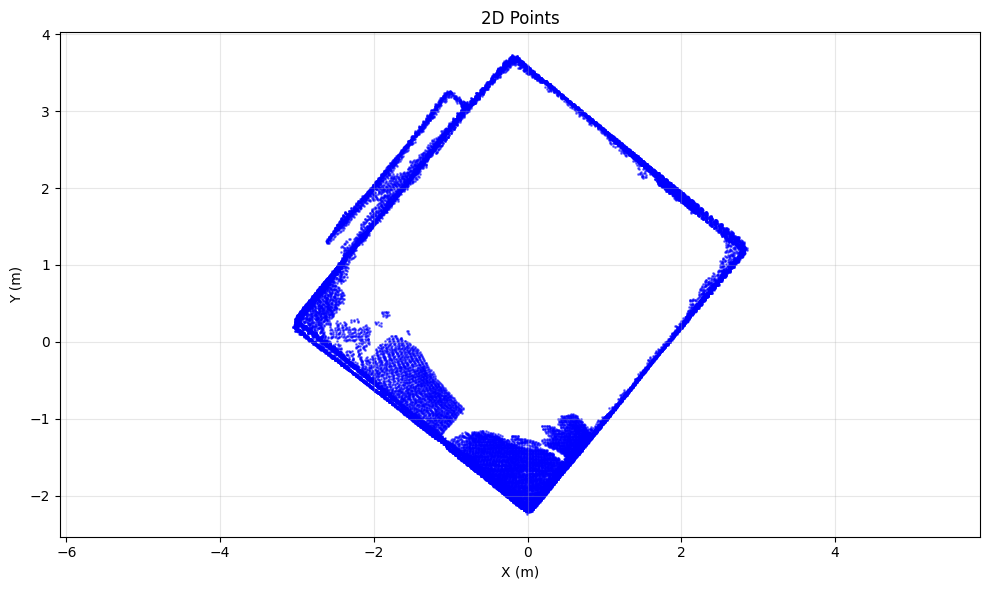

In [18]:
ceiling_points_2d = all_clean_ceiling_points[: , :2]

visualize_2d_points(ceiling_points_2d)

### BY WALL

In [19]:
ceiling_indices = np.hstack([level["indices"] for level in refined_ceiling_levels])

In [20]:
segmentation = segment_floor_ceiling_walls(
    points,
    ceiling_indices=ceiling_indices,
    floor_method='histogram_ransac',
    bottom_slice_height=0.30,
    floor_ransac_threshold=0.02
)


  Running RANSAC on bottom slice only...
    ✓ Plane is horizontal
    RANSAC inliers in slice: 36,624
    Expanded to all points (±0.1m): 55,200
    Additional floor points found: 18,576

Room height:    2.659m (floor: -1.808m, ceiling: 0.851m)


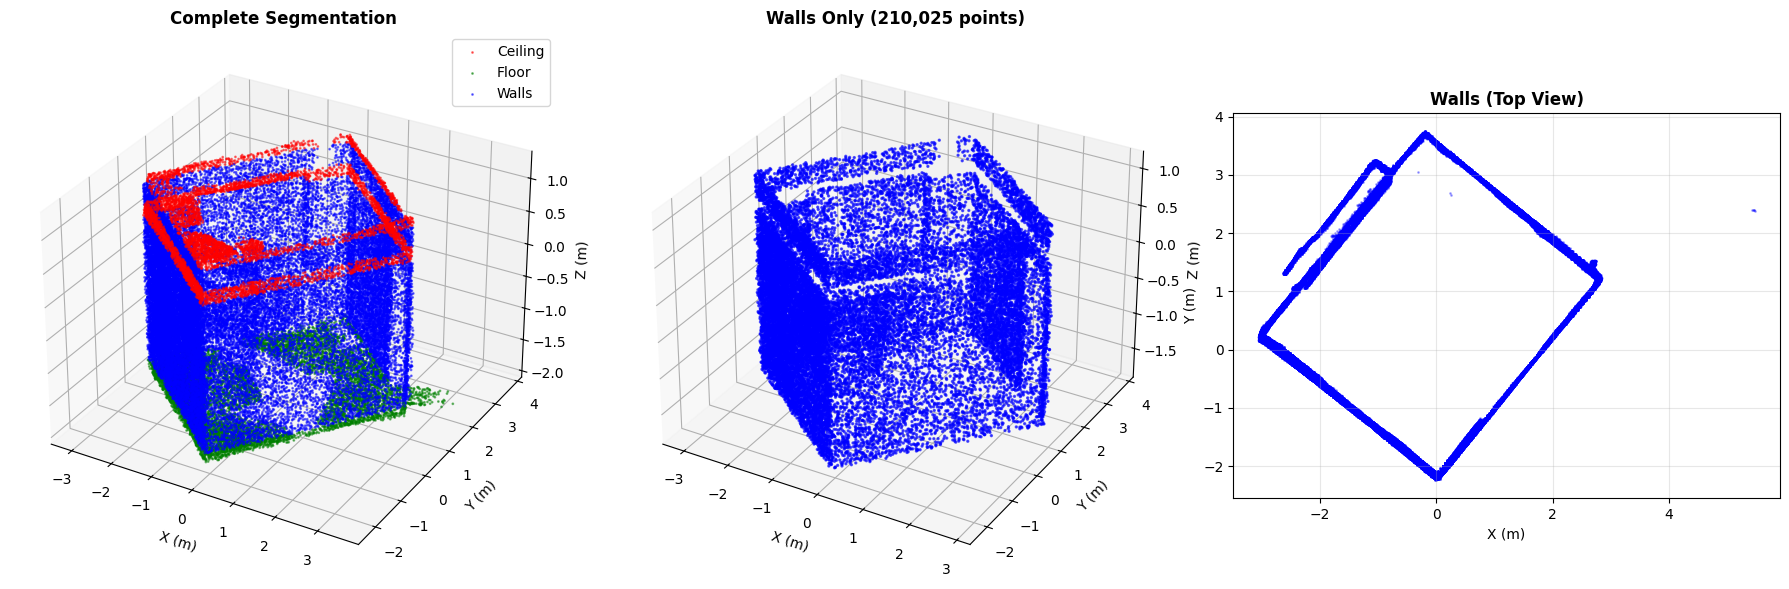

In [21]:
visualize_segmentation(points, segmentation, subsample=50000)

In [22]:
floor_height, ceiling_height = sem_seg.ransac_segmentor.get_floor_height(), sem_seg.ransac_segmentor.get_ceiling_height()

In [23]:
segmentation["ceiling_height"]

np.float64(0.850763167890191)

In [24]:
floor_height, ceiling_height

(np.float64(-1.8112281333333333), np.float64(1.0414431999999996))

In [25]:
ceiling_height - floor_height

np.float64(2.852671333333333)

In [26]:
wall_result = extract_walls_complete_pipeline(
    points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    floor_margin=0.10,        # 10cm margin
    ceiling_margin=0.25,      # 10cm margin
    normal_radius=0.10,       # 10cm for normal estimation
    max_nn=30,
    vertical_threshold=0.15   # |normal_z| < 0.15 = vertical
)

  Excluded: 90,447 points (30.3%)


In [27]:
vertical_points = wall_result["wall_points"]
vertical_normals = wall_result["wall_normals"]

In [28]:
# visualize_wall_points_3d(vertical_points, vertical_normals)

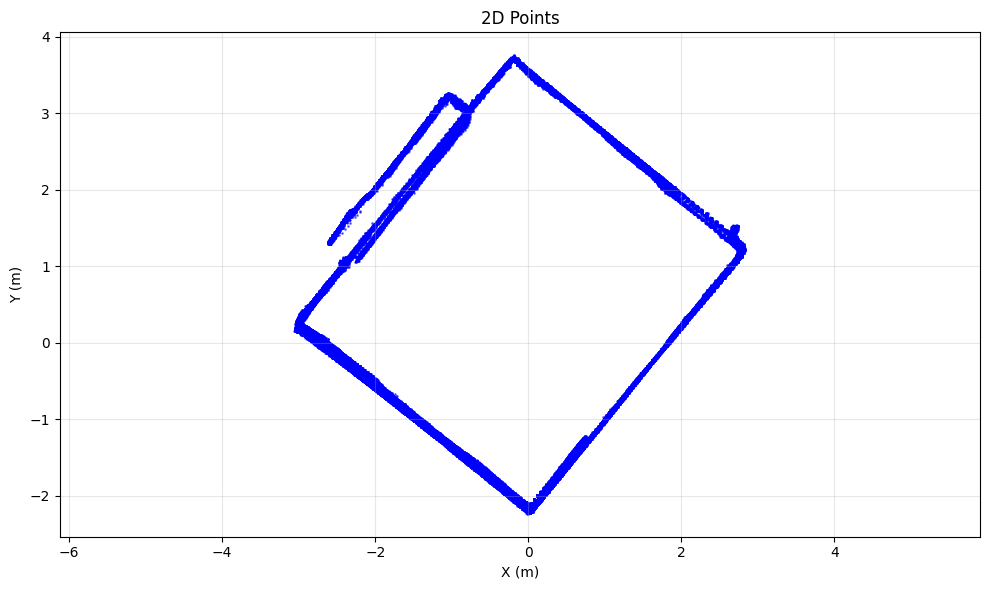

In [29]:
wall_points_2d = vertical_points[: , :2]
visualize_2d_points(wall_points_2d)

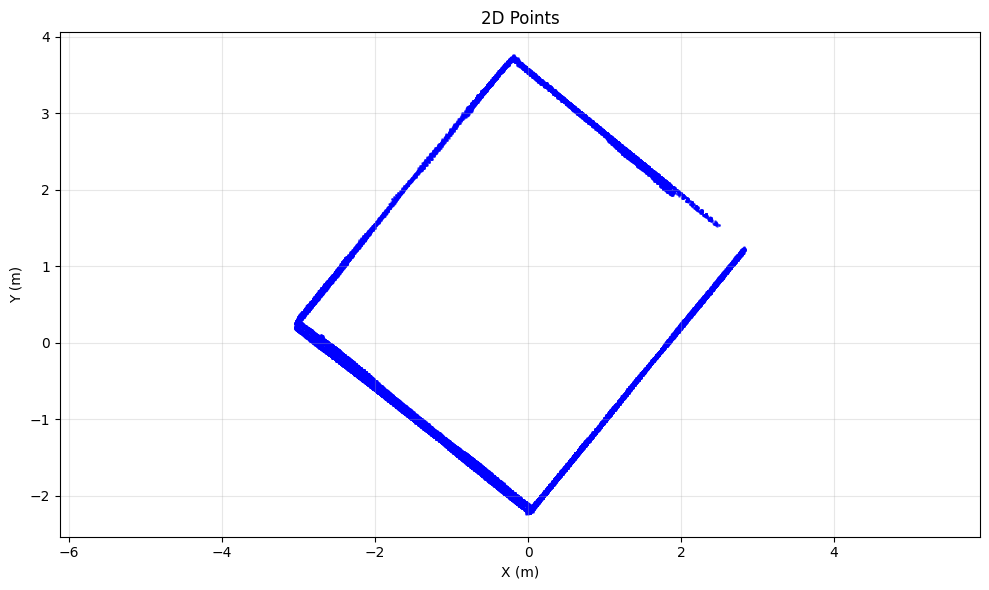

In [30]:
walls = detect_walls_ransac_clustering(
    vertical_points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    distance_threshold=0.02,      
    cluster_eps=0.12,             
    min_cluster_points=50,       
    min_wall_height=1.8,          
    min_wall_length=0.10,
    max_wall_thickness=0.25,      
    min_height_ratio=0.60,
    max_iterations=30
)
wall_points = get_room_wall_points(walls)
wall_points_2d = project_points_to_2d(wall_points)
visualize_2d_points(wall_points_2d)

In [31]:
config = {
    'distance_threshold': 0.02,
    'cluster_eps': 0.12,
    'min_cluster_points': 50,
    'min_wall_height': 1.8,
    'min_wall_length': 0.10,
    'max_wall_thickness': 0.25,
    'min_height_ratio': 0.60,
    'max_iterations': 30
}

ensemble_result = ensemble_ransac_wall_detection(
    vertical_points,
    floor_height,
    ceiling_height,
    n_runs=7,
    config=config
)

wall_points_2d = ensemble_result['consensus_points'][:, :2]

100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


Voting distribution:
  0 votes: 24,352 points (14.3%)
  1 votes: 3,272 points (1.9%)
  2 votes: 3,719 points (2.2%)
  3 votes: 3,518 points (2.1%)
  4 votes: 4,137 points (2.4%)
  5 votes: 7,831 points (4.6%)
  6 votes: 11,392 points (6.7%)
  7 votes: 112,634 points (65.9%)


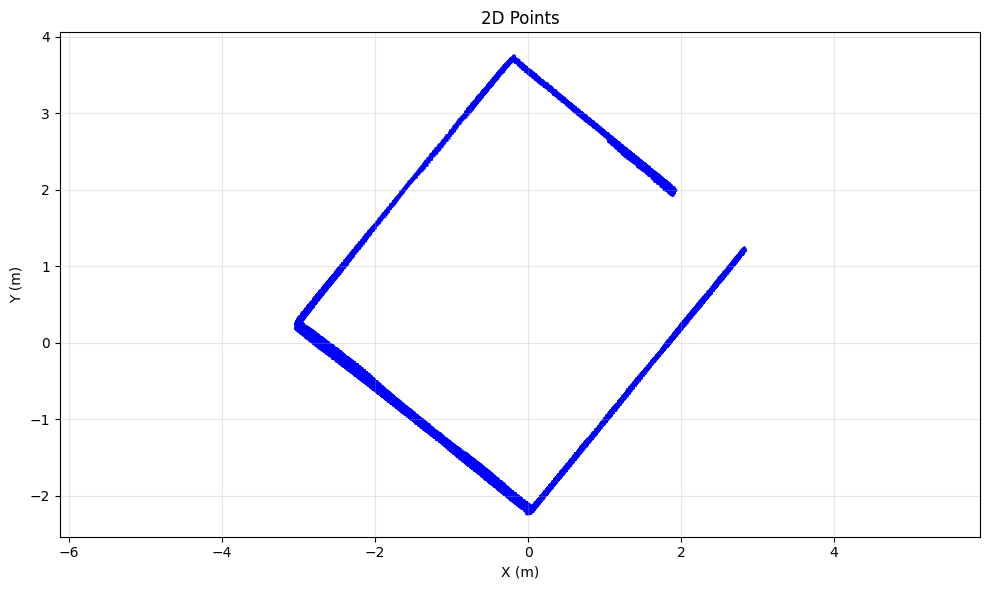

In [32]:
visualize_2d_points(wall_points_2d)

### workflow

In [33]:
a, b = 4410 / 1000, 3940 / 1000
p = a + a + b + b
S = a * b

In [34]:
median_thickness = np.median([wall["thickness"] for wall in walls])

In [36]:
study, best_params = run_optuna_optimization(
    wall_points_2d=wall_points_2d,
    method='concave_hull',
    median_thickness=median_thickness / 2,
    ground_truth={'perimeter': p, 'area': S},
    optimize='both',
    split=0.5,
    n_trials=300, 
    timeout=None 
)


BAYESIAN OPTIMIZATION WITH OPTUNA
Optimization: both
Weights: Perimeter=50.0%, Area=50.0%
Ground truth: Perimeter=16.70m, Area=17.38m²
Number of trials: 300


Best trial: 0. Best value: 0.0920597: 100%|██████████| 300/300 [01:37<00:00,  3.08it/s]


OPTIMIZATION COMPLETE
Number of finished trials: 300
Number of complete trials: 300


In [37]:
best_params

{'concave_ratio': 0.6441332836174088,
 'simplification': ('vw', 0.21129933099440734)}

In [52]:
best_params = {'median_thickness_ratio': 0.4776443425609927,
 'concave_ratio': 0.3018857245013067,
 'simplification': ('vw', 0.16949651760901654)}

In [53]:
boundary_polygon = extract_room_boundary_from_walls(
    wall_points_2d,
    method='concave_hull',
    concave_ratio=best_params["concave_ratio"]
)

In [54]:
# thickness from RANSAC step
offset_implicit = offset_boundary_inward(
    boundary_polygon,
    offset_distance=median_thickness * 0.4776443425609927
)

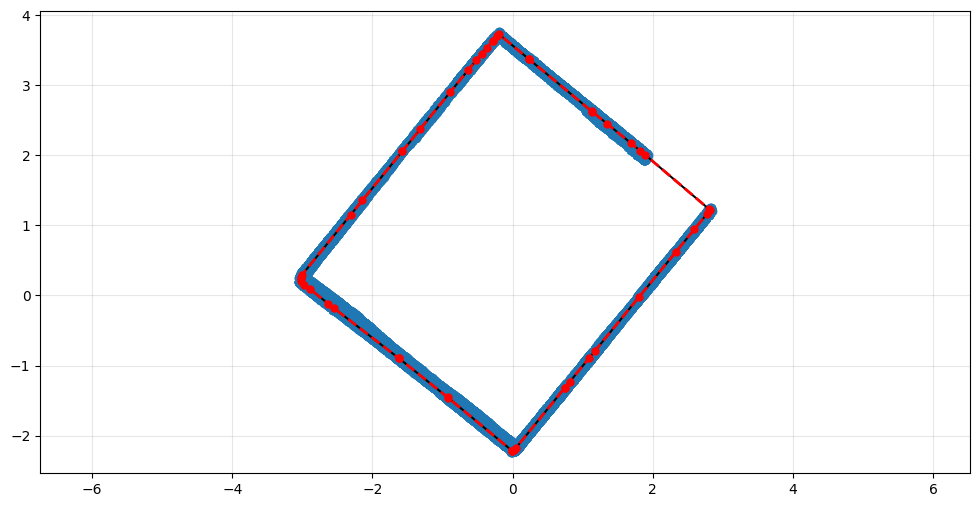

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

if offset_implicit.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = offset_implicit.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


POLYGON DIMENSIONS
Number of corners: 5
Wall  1: Corner 1 → Corner 2, Length:  0.133m, Angle:   44.8°
Wall  2: Corner 2 → Corner 3, Length:  3.899m, Angle:  320.2°
Wall  3: Corner 3 → Corner 4, Length:  4.388m, Angle:  231.0°
Wall  4: Corner 4 → Corner 5, Length:  3.884m, Angle:  142.2°
Wall  5: Corner 5 → Corner 1, Length:  4.390m, Angle:   51.4°

──────────────────────────────────────────────────────────────────────
Total perimeter: 16.695m
Total area:      17.369m²


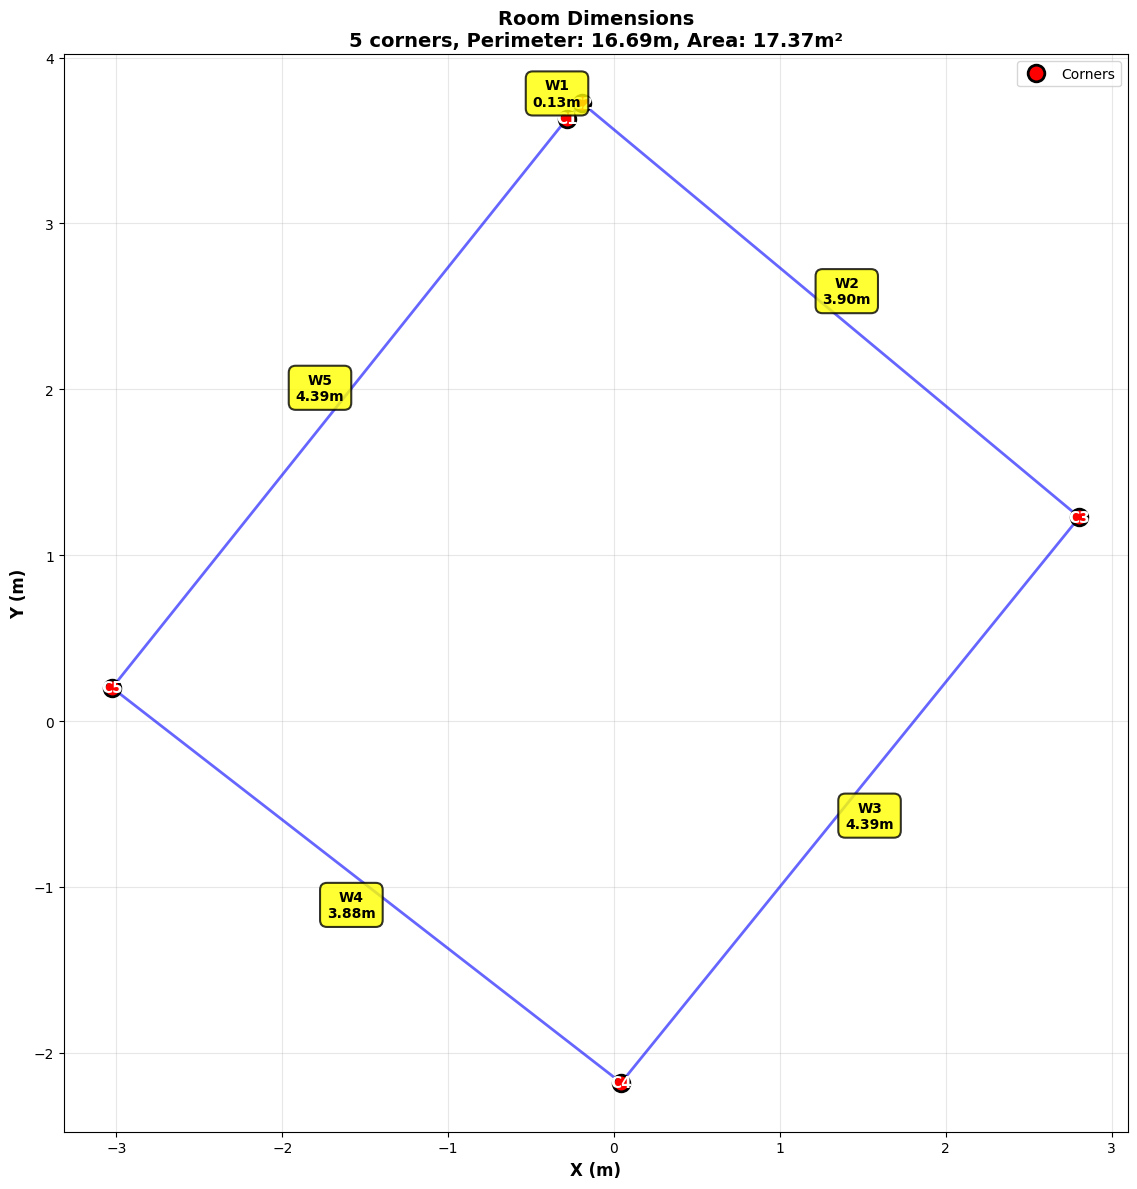

In [56]:
if best_params["simplification"][0] == "dp":
    simplified_boundary = offset_implicit.simplify(best_params["simplification"][1], preserve_topology=True)
    dimensions = compute_polygon_dimensions(simplified_boundary)
    visualize_polygon_dimensions(simplified_boundary, dimensions)
elif best_params["simplification"][0] == "vw":
    simplified_points = simplify_coords_vw(np.array(offset_implicit.exterior.coords),
                                       epsilon=best_params["simplification"][1])
    dimensions = compute_polygon_dimensions(Polygon(simplified_points))
    visualize_polygon_dimensions(Polygon(simplified_points), dimensions)
else:
    dimensions = compute_polygon_dimensions(offset_implicit)
    visualize_polygon_dimensions(offset_implicit, dimensions)


POLYGON DIMENSIONS
Number of corners: 5
Wall  1: Corner 1 → Corner 2, Length:  0.132m, Angle:   44.9°
Wall  2: Corner 2 → Corner 3, Length:  3.898m, Angle:  320.2°
Wall  3: Corner 3 → Corner 4, Length:  4.387m, Angle:  231.0°
Wall  4: Corner 4 → Corner 5, Length:  3.882m, Angle:  142.2°
Wall  5: Corner 5 → Corner 1, Length:  4.389m, Angle:   51.4°

──────────────────────────────────────────────────────────────────────
Total perimeter: 16.688m
Total area:      17.355m²


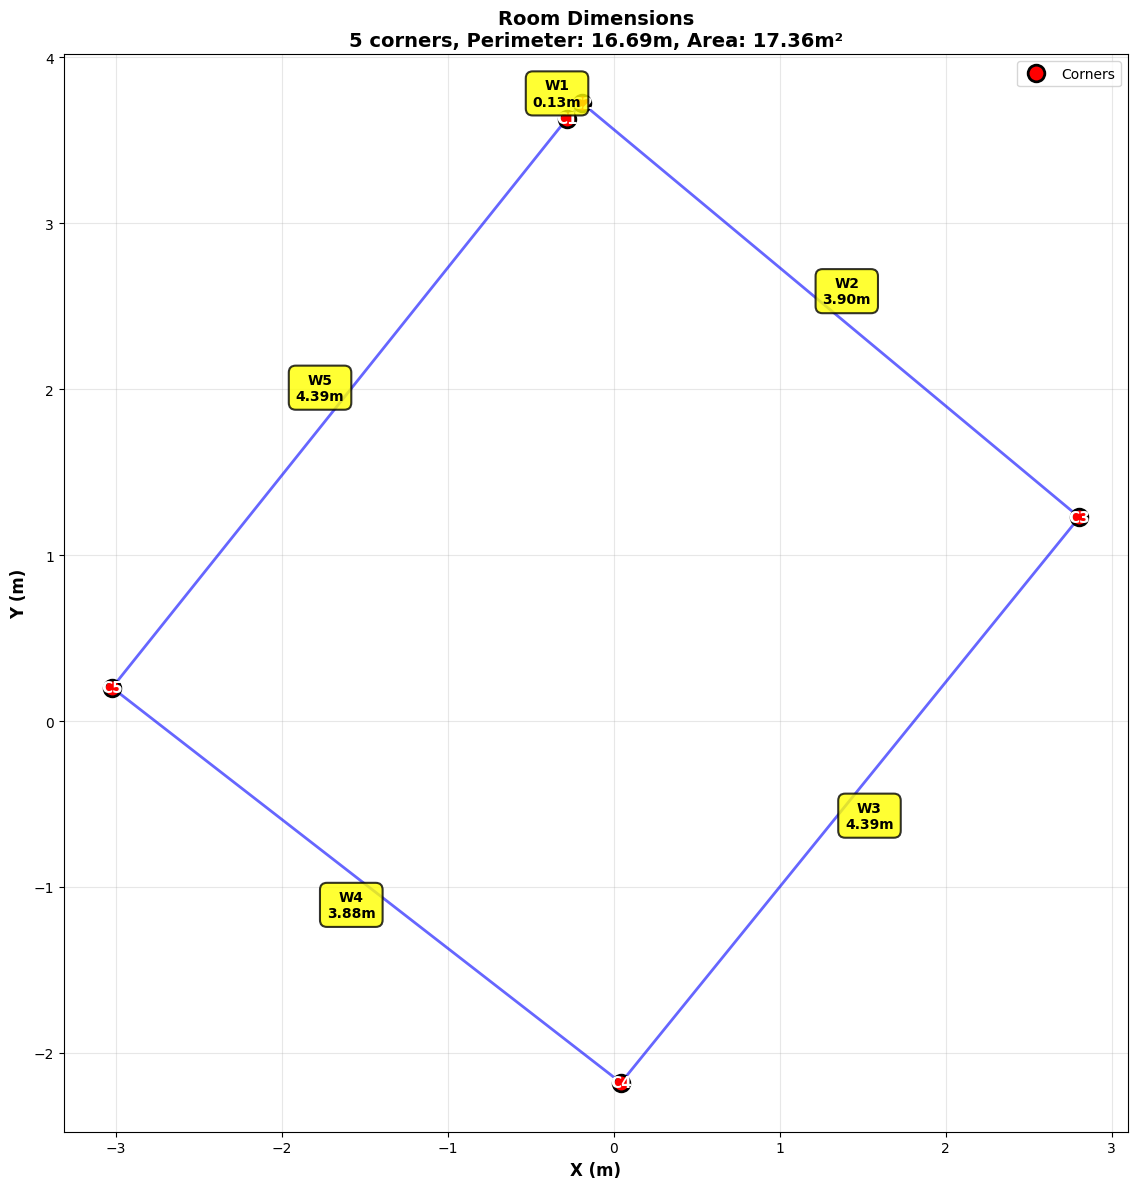

In [41]:
if best_params["simplification"][0] == "dp":
    simplified_boundary = offset_implicit.simplify(best_params["simplification"][1], preserve_topology=True)
    dimensions = compute_polygon_dimensions(simplified_boundary)
    visualize_polygon_dimensions(simplified_boundary, dimensions)
elif best_params["simplification"][0] == "vw":
    simplified_points = simplify_coords_vw(np.array(offset_implicit.exterior.coords),
                                       epsilon=best_params["simplification"][1])
    dimensions = compute_polygon_dimensions(Polygon(simplified_points))
    visualize_polygon_dimensions(Polygon(simplified_points), dimensions)
else:
    dimensions = compute_polygon_dimensions(offset_implicit)
    visualize_polygon_dimensions(offset_implicit, dimensions)


In [42]:
def distribute_small_segments_proportional_local(dimensions, min_wall_length=0.25):
    """
    Distribute small segments to adjacent neighbors, but proportionally
    
    This is a middle ground:
    - Only affects immediate neighbors (preserves shape)
    - Distribution is proportional to neighbor lengths (fairer than 50/50)
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions
    min_wall_length : float
        Segments shorter than this are distributed
    
    Returns:
    --------
    new_dimensions : list of dict
        Adjusted dimensions
    """
    
    import numpy as np
    
    print(f"\n{'='*70}")
    print(f"PROPORTIONAL LOCAL DISTRIBUTION")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Min wall length: {min_wall_length}m")
    
    # Step 1: Identify small segments
    small_indices = []
    for i, wall in enumerate(dimensions):
        if wall['length'] < min_wall_length:
            small_indices.append(i)
    
    if len(small_indices) == 0:
        print(f"No small segments found")
        return dimensions
    
    print(f"\nFound {len(small_indices)} small segment(s):")
    for idx in small_indices:
        wall = dimensions[idx]
        prev_idx = (idx - 1) % len(dimensions)
        next_idx = (idx + 1) % len(dimensions)
        
        prev_wall = dimensions[prev_idx]
        next_wall = dimensions[next_idx]
        
        # Calculate proportional split
        total_neighbor_length = prev_wall['length'] + next_wall['length']
        ratio_to_prev = prev_wall['length'] / total_neighbor_length if total_neighbor_length > 0 else 0.5
        ratio_to_next = next_wall['length'] / total_neighbor_length if total_neighbor_length > 0 else 0.5
        
        print(f"\n  Wall {wall['wall_id']}: {wall['length']:.3f}m")
        print(f"    Prev wall {prev_wall['wall_id']}: {prev_wall['length']:.3f}m")
        print(f"    Next wall {next_wall['wall_id']}: {next_wall['length']:.3f}m")
        print(f"    Split ratio: {ratio_to_prev:.1%} / {ratio_to_next:.1%}")
    
    # Step 2: Calculate new corner positions
    new_corners = {}
    
    for idx in small_indices:
        wall = dimensions[idx]
        prev_idx = (idx - 1) % len(dimensions)
        next_idx = (idx + 1) % len(dimensions)
        
        prev_wall = dimensions[prev_idx]
        next_wall = dimensions[next_idx]
        
        # Proportional split
        total_neighbor_length = prev_wall['length'] + next_wall['length']
        ratio_to_prev = prev_wall['length'] / total_neighbor_length if total_neighbor_length > 0 else 0.5
        
        # New corner position (interpolate along small segment)
        new_corner = wall['start_point'] + ratio_to_prev * (wall['end_point'] - wall['start_point'])
        new_corners[idx] = new_corner
        
        amount_to_prev = wall['length'] * ratio_to_prev
        amount_to_next = wall['length'] * ratio_to_next
        
        print(f"\n  Distributing Wall {wall['wall_id']}:")
        print(f"    To prev wall {prev_wall['wall_id']}: {amount_to_prev:.3f}m")
        print(f"    To next wall {next_wall['wall_id']}: {amount_to_next:.3f}m")
    
    # Step 3: Build new dimensions
    new_dimensions = []
    
    for i, wall in enumerate(dimensions):
        if i in small_indices:
            continue
        
        new_wall = wall.copy()
        
        # Check if previous wall was small
        prev_idx = (i - 1) % len(dimensions)
        if prev_idx in small_indices:
            new_wall['start_point'] = new_corners[prev_idx]
        
        # Check if next wall is small
        next_idx = (i + 1) % len(dimensions)
        if next_idx in small_indices:
            new_wall['end_point'] = new_corners[next_idx]
        
        # Recalculate
        vec = new_wall['end_point'] - new_wall['start_point']
        old_length = new_wall['length']
        new_wall['length'] = np.linalg.norm(vec)
        new_wall['angle'] = np.degrees(np.arctan2(vec[1], vec[0])) % 360
        
        if abs(new_wall['length'] - old_length) > 0.001:
            change = new_wall['length'] - old_length
            print(f"    Wall {wall['wall_id']}: {old_length:.3f}m → {new_wall['length']:.3f}m "
                  f"({change:+.3f}m)")
        
        new_dimensions.append(new_wall)
    
    # Renumber
    for idx, wall in enumerate(new_dimensions, 1):
        wall['wall_id'] = idx
        wall['corner_start'] = idx
        wall['corner_end'] = (idx % len(new_dimensions)) + 1
    
    print(f"\n✓ Result: {len(dimensions)} → {len(new_dimensions)} walls")
    
    return new_dimensions

In [57]:
merged = distribute_small_segments_proportional_local(dimensions)


PROPORTIONAL LOCAL DISTRIBUTION
Input walls: 5
Min wall length: 0.25m

Found 1 small segment(s):

  Wall 1: 0.133m
    Prev wall 5: 4.390m
    Next wall 2: 3.899m
    Split ratio: 53.0% / 47.0%

  Distributing Wall 1:
    To prev wall 5: 0.070m
    To next wall 2: 0.063m
    Wall 2: 3.899m → 3.905m (+0.006m)
    Wall 5: 4.390m → 4.460m (+0.070m)

✓ Result: 5 → 4 walls


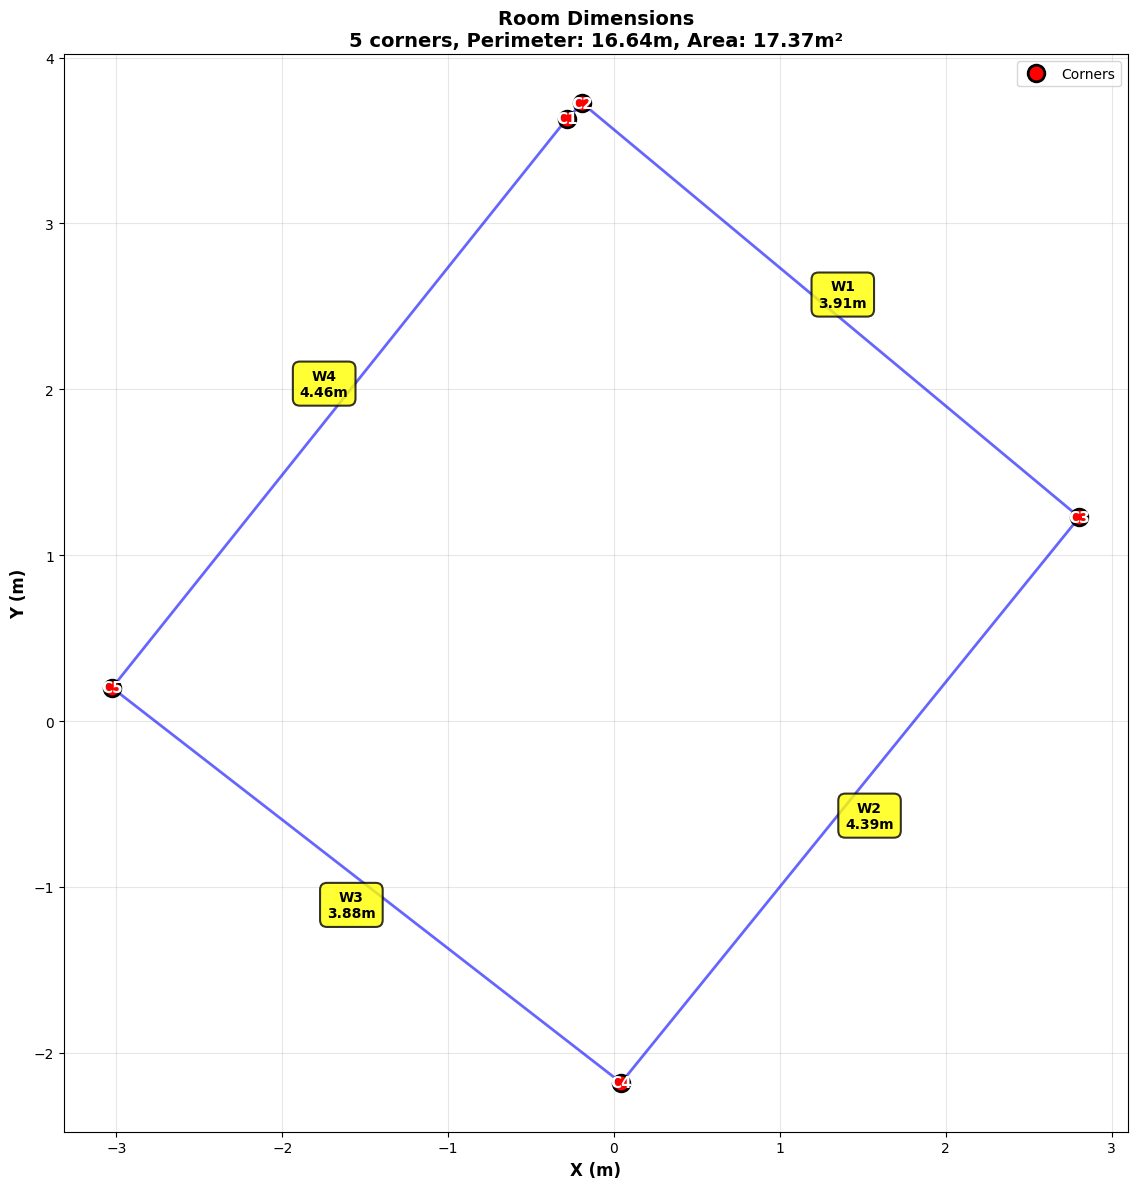

In [58]:
visualize_polygon_dimensions(Polygon(simplified_points), merged)

In [46]:
(3.88 - 3.94) / 3.94

-0.0152284263959391

In [47]:
(16.63 - p) / p

-0.004191616766467083

In [59]:
(17.37 - 17.38) / 17.38

-0.0005753739930953976

In [152]:
def merge_nearby_vertices_simple(polygon_points, distance_threshold=0.10):
    """
    Merge consecutive vertices that are very close together
    
    This preserves perimeter accuracy while reducing vertex count!
    
    Parameters:
    -----------
    polygon_points : np.ndarray (N, 2)
        Polygon vertices in order
    distance_threshold : float
        Merge vertices closer than this (meters)
    
    Returns:
    --------
    merged_points : np.ndarray (M, 2)
        Simplified polygon (M ≤ N)
    """
    
    print(f"\n{'='*70}")
    print(f"SIMPLE VERTEX MERGING")
    print(f"{'='*70}")
    print(f"Input vertices: {len(polygon_points)}")
    print(f"Distance threshold: {distance_threshold}m")
    
    if len(polygon_points) < 3:
        return polygon_points
    
    merged = [polygon_points[0]]
    
    for i in range(1, len(polygon_points)):
        current = polygon_points[i]
        previous = merged[-1]
        
        distance = np.linalg.norm(current - previous)
        
        if distance >= distance_threshold:
            # Far enough, keep this vertex
            merged.append(current)
        else:
            # Too close, skip (merge with previous)
            print(f"  Merging vertex {i} with previous (distance: {distance:.3f}m)")
    
    # Check wrap-around (last to first)
    if len(merged) > 1:
        distance_to_start = np.linalg.norm(merged[-1] - merged[0])
        if distance_to_start < distance_threshold:
            print(f"  Merging last vertex with first (distance: {distance_to_start:.3f}m)")
            merged = merged[:-1]
    
    merged_points = np.array(merged)
    
    print(f"\n✓ Result: {len(polygon_points)} → {len(merged_points)} vertices")
    
    # Check perimeter preservation
    from shapely.geometry import Polygon
    original_perim = Polygon(polygon_points).length
    merged_perim = Polygon(merged_points).length
    
    print(f"\nPerimeter check:")
    print(f"  Original: {original_perim:.3f}m")
    print(f"  Merged:   {merged_perim:.3f}m")
    print(f"  Diff:     {abs(original_perim - merged_perim):.3f}m "
          f"({100*abs(original_perim - merged_perim)/original_perim:.2f}%)")
    
    return merged_points

In [153]:
simplified_points = np.array(offset_implicit.exterior.coords)

In [154]:
merged_points = merge_nearby_vertices_simple(simplified_points)


SIMPLE VERTEX MERGING
Input vertices: 49
Distance threshold: 0.1m
  Merging vertex 1 with previous (distance: 0.094m)
  Merging vertex 3 with previous (distance: 0.004m)
  Merging vertex 5 with previous (distance: 0.000m)
  Merging vertex 7 with previous (distance: 0.001m)
  Merging vertex 10 with previous (distance: 0.006m)
  Merging vertex 11 with previous (distance: 0.018m)
  Merging vertex 13 with previous (distance: 0.080m)
  Merging vertex 17 with previous (distance: 0.000m)
  Merging vertex 19 with previous (distance: 0.055m)
  Merging vertex 22 with previous (distance: 0.082m)
  Merging vertex 24 with previous (distance: 0.036m)
  Merging vertex 25 with previous (distance: 0.049m)
  Merging vertex 27 with previous (distance: 0.001m)
  Merging vertex 29 with previous (distance: 0.001m)
  Merging vertex 31 with previous (distance: 0.055m)
  Merging vertex 33 with previous (distance: 0.060m)
  Merging vertex 35 with previous (distance: 0.075m)
  Merging vertex 37 with previous (d

In [93]:
def merge_collinear_walls(dimensions, 
                         angle_tolerance=5.0,
                         max_gap=0.10):
    """
    Merge walls that are collinear (on same line)
    
    Strategy:
    1. Find pairs of consecutive walls with similar angles
    2. Check if they're collinear (approximately on same line)
    3. Merge them into single wall
    4. Repeat until no more merges possible
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions from compute_polygon_dimensions()
    angle_tolerance : float
        Max angle difference to consider collinear (degrees)
    max_gap : float
        Maximum gap between walls to merge (meters)
    
    Returns:
    --------
    merged_dimensions : list of dict
        Merged wall dimensions
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING COLLINEAR WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Angle tolerance: {angle_tolerance}°")
    print(f"Max gap: {max_gap}m")
    
    merged = []
    skip_indices = set()
    
    i = 0
    while i < len(dimensions):
        if i in skip_indices:
            i += 1
            continue
        
        # Start new merged segment
        current = dimensions[i]
        merge_chain = [i]
        
        # Try to extend forward
        j = i + 1
        while j < len(dimensions):
            if j in skip_indices:
                j += 1
                continue
            
            next_wall = dimensions[j]
            
            # Check angle similarity
            angle_diff = abs(current['angle'] - next_wall['angle'])
            # Handle wrap-around (e.g., 359° and 1°)
            angle_diff = min(angle_diff, 360 - angle_diff)
            
            if angle_diff <= angle_tolerance:
                # Check gap
                gap = np.linalg.norm(current['end_point'] - next_wall['start_point'])
                
                if gap <= max_gap:
                    # Merge!
                    merge_chain.append(j)
                    current = next_wall  # Continue from this wall
                    j += 1
                else:
                    # Gap too large
                    break
            else:
                # Angle too different
                break
        
        # Create merged wall from chain
        if len(merge_chain) == 1:
            # No merge, keep original
            merged.append(dimensions[i])
        else:
            # Merge multiple walls
            first_wall = dimensions[merge_chain[0]]
            last_wall = dimensions[merge_chain[-1]]
            
            # New wall from first start to last end
            merged_start = first_wall['start_point']
            merged_end = last_wall['end_point']
            merged_vec = merged_end - merged_start
            merged_length = np.linalg.norm(merged_vec)
            merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
            
            # Sum of individual lengths (for comparison)
            total_length = sum(dimensions[idx]['length'] for idx in merge_chain)
            
            merged_wall = {
                'wall_id': len(merged) + 1,
                'start_point': merged_start,
                'end_point': merged_end,
                'length': merged_length,
                'angle': merged_angle,
                'merged_from': merge_chain,
                'num_segments': len(merge_chain)
            }
            
            merged.append(merged_wall)
            
            print(f"  Merged {len(merge_chain)} walls (indices {merge_chain[0]}-{merge_chain[-1]}): "
                  f"{total_length:.2f}m → {merged_length:.2f}m")
            
            # Mark as processed
            skip_indices.update(merge_chain)
        
        i += 1
    
    print(f"\n✓ Result: {len(dimensions)} → {len(merged)} walls")
    
    # Renumber
    for idx, wall in enumerate(merged, 1):
        wall['wall_id'] = idx
    
    return merged


def merge_short_walls(dimensions, min_wall_length=0.30):
    """
    Merge very short walls with their neighbors
    
    Strategy:
    - Find walls shorter than threshold
    - Merge with neighbor (prefer same angle)
    - Repeat
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions
    min_wall_length : float
        Walls shorter than this get merged (meters)
    
    Returns:
    --------
    merged : list of dict
        Dimensions with short walls merged
    """
    
    print(f"\n{'='*70}")
    print(f"MERGING SHORT WALLS")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Min wall length: {min_wall_length}m")
    
    # Convert to list for easier manipulation
    walls = list(dimensions)
    
    iterations = 0
    max_iterations = 50
    
    while iterations < max_iterations:
        iterations += 1
        
        # Find shortest wall
        shortest_idx = None
        shortest_length = float('inf')
        
        for i, wall in enumerate(walls):
            if wall['length'] < min_wall_length and wall['length'] < shortest_length:
                shortest_idx = i
                shortest_length = wall['length']
        
        if shortest_idx is None:
            # No more short walls
            break
        
        # Merge with neighbor
        n = len(walls)
        prev_idx = (shortest_idx - 1) % n
        next_idx = (shortest_idx + 1) % n
        
        short_wall = walls[shortest_idx]
        prev_wall = walls[prev_idx]
        next_wall = walls[next_idx]
        
        # Decide which neighbor to merge with (prefer similar angle)
        angle_diff_prev = abs(short_wall['angle'] - prev_wall['angle'])
        angle_diff_prev = min(angle_diff_prev, 360 - angle_diff_prev)
        
        angle_diff_next = abs(short_wall['angle'] - next_wall['angle'])
        angle_diff_next = min(angle_diff_next, 360 - angle_diff_next)
        
        if angle_diff_prev < angle_diff_next:
            # Merge with previous
            merge_with = prev_idx
            keep_idx = prev_idx
            remove_idx = shortest_idx
        else:
            # Merge with next
            merge_with = shortest_idx
            keep_idx = shortest_idx
            remove_idx = next_idx
        
        # Create merged wall
        if merge_with == prev_idx:
            merged_start = prev_wall['start_point']
            merged_end = short_wall['end_point']
        else:
            merged_start = short_wall['start_point']
            merged_end = next_wall['end_point']
        
        merged_vec = merged_end - merged_start
        merged_length = np.linalg.norm(merged_vec)
        merged_angle = np.degrees(np.arctan2(merged_vec[1], merged_vec[0])) % 360
        
        walls[keep_idx] = {
            'wall_id': keep_idx + 1,
            'start_point': merged_start,
            'end_point': merged_end,
            'length': merged_length,
            'angle': merged_angle
        }
        
        # Remove the other wall
        walls.pop(remove_idx)
        
        print(f"  Iteration {iterations}: Merged wall {remove_idx+1} ({shortest_length:.2f}m) → "
              f"New length: {merged_length:.2f}m")
    
    print(f"\n✓ Result: {len(dimensions)} → {len(walls)} walls")
    
    # Renumber
    for idx, wall in enumerate(walls, 1):
        wall['wall_id'] = idx
    
    return walls


def merge_walls_complete(dimensions, 
                        angle_tolerance=8.0,
                        max_gap=0.15,
                        min_wall_length=0.50):
    """
    Complete wall merging pipeline
    
    Step 1: Merge collinear walls
    Step 2: Merge short walls with neighbors
    Step 3: Repeat until stable
    """
    
    print(f"\n{'='*70}")
    print(f"COMPLETE WALL MERGING PIPELINE")
    print(f"{'='*70}")
    print(f"Initial walls: {len(dimensions)}")
    
    current = dimensions
    prev_count = len(current)
    
    for iteration in range(5):  # Max 5 rounds
        print(f"\n{'-'*70}")
        print(f"ROUND {iteration + 1}")
        print(f"{'-'*70}")
        
        # Step 1: Merge collinear
        current = merge_collinear_walls(
            current,
            angle_tolerance=angle_tolerance,
            max_gap=max_gap
        )
        
        # Step 2: Merge short
        current = merge_short_walls(
            current,
            min_wall_length=min_wall_length
        )
        
        # Check if stable
        new_count = len(current)
        if new_count == prev_count:
            print(f"\n✓ Converged after {iteration + 1} rounds")
            break
        
        prev_count = new_count
    
    print(f"\n{'='*70}")
    print(f"MERGING COMPLETE")
    print(f"{'='*70}")
    print(f"Final walls: {len(current)}")
    print(f"Reduction: {len(dimensions)} → {len(current)} "
          f"({100*(len(dimensions)-len(current))/len(dimensions):.1f}%)")
    
    return current

In [104]:
dimensions

[{'wall_id': 1,
  'corner_start': 1,
  'corner_end': 2,
  'start_point': array([-2.96815411,  0.32043953]),
  'end_point': array([-0.19096383,  3.70792103]),
  'length': np.float64(4.380390023672633),
  'angle': np.float64(50.6537553208784)},
 {'wall_id': 2,
  'corner_start': 2,
  'corner_end': 3,
  'start_point': array([-0.19096383,  3.70792103]),
  'end_point': array([1.9127698, 1.9810864]),
  'length': np.float64(2.7217003999541727),
  'angle': np.float64(320.6193849489122)},
 {'wall_id': 3,
  'corner_start': 3,
  'corner_end': 4,
  'start_point': array([1.9127698, 1.9810864]),
  'end_point': array([2.79817044, 1.21377796]),
  'length': np.float64(1.1716213206153512),
  'angle': np.float64(319.0870497947674)},
 {'wall_id': 4,
  'corner_start': 4,
  'corner_end': 5,
  'start_point': array([2.79817044, 1.21377796]),
  'end_point': array([ 0.34224551, -1.79709436]),
  'length': np.float64(3.8854754395475224),
  'angle': np.float64(230.79637313316883)},
 {'wall_id': 5,
  'corner_start':

In [94]:
merged_dimensions = merge_walls_complete(
    dimensions,
    angle_tolerance=60.0,      # Walls within 8° are considered same direction
    max_gap=0.15,             # Walls < 15cm apart can merge
    min_wall_length=0.25     # Walls < 50cm get merged with neighbors
)


COMPLETE WALL MERGING PIPELINE
Initial walls: 8

----------------------------------------------------------------------
ROUND 1
----------------------------------------------------------------------

MERGING COLLINEAR WALLS
Input walls: 8
Angle tolerance: 60.0°
Max gap: 0.15m
  Merged 2 walls (indices 1-2): 3.89m → 3.89m
  Merged 2 walls (indices 3-4): 4.42m → 4.42m
  Merged 2 walls (indices 5-6): 3.85m → 3.85m

✓ Result: 8 → 5 walls

MERGING SHORT WALLS
Input walls: 5
Min wall length: 0.25m
  Iteration 1: Merged wall 1 (0.12m) → New length: 4.50m

✓ Result: 5 → 4 walls

----------------------------------------------------------------------
ROUND 2
----------------------------------------------------------------------

MERGING COLLINEAR WALLS
Input walls: 4
Angle tolerance: 60.0°
Max gap: 0.15m

✓ Result: 4 → 4 walls

MERGING SHORT WALLS
Input walls: 4
Min wall length: 0.25m

✓ Result: 4 → 4 walls

✓ Converged after 2 rounds

MERGING COMPLETE
Final walls: 4
Reduction: 8 → 4 (50.0%)


In [95]:
merged_dimensions

[{'wall_id': 1,
  'start_point': array([-0.19096383,  3.70792103]),
  'end_point': array([2.79817044, 1.21377796]),
  'length': np.float64(3.8930288133939084),
  'angle': np.float64(320.1582730512735),
  'merged_from': [1, 2],
  'num_segments': 2},
 {'wall_id': 2,
  'start_point': array([2.79817044, 1.21377796]),
  'end_point': array([-0.0081065 , -2.19933308]),
  'length': np.float64(4.4186555902524365),
  'angle': np.float64(230.57278681565083),
  'merged_from': [3, 4],
  'num_segments': 2},
 {'wall_id': 3,
  'start_point': array([-0.0081065 , -2.19933308]),
  'end_point': array([-3.01194693,  0.20462637]),
  'length': np.float64(3.847346922790145),
  'angle': np.float64(141.32987559586473),
  'merged_from': [5, 6],
  'num_segments': 2},
 {'wall_id': 4,
  'start_point': array([-3.01194693,  0.20462637]),
  'end_point': array([-0.19096383,  3.70792103]),
  'length': np.float64(4.497890513205853),
  'angle': np.float64(51.15769033026903)}]

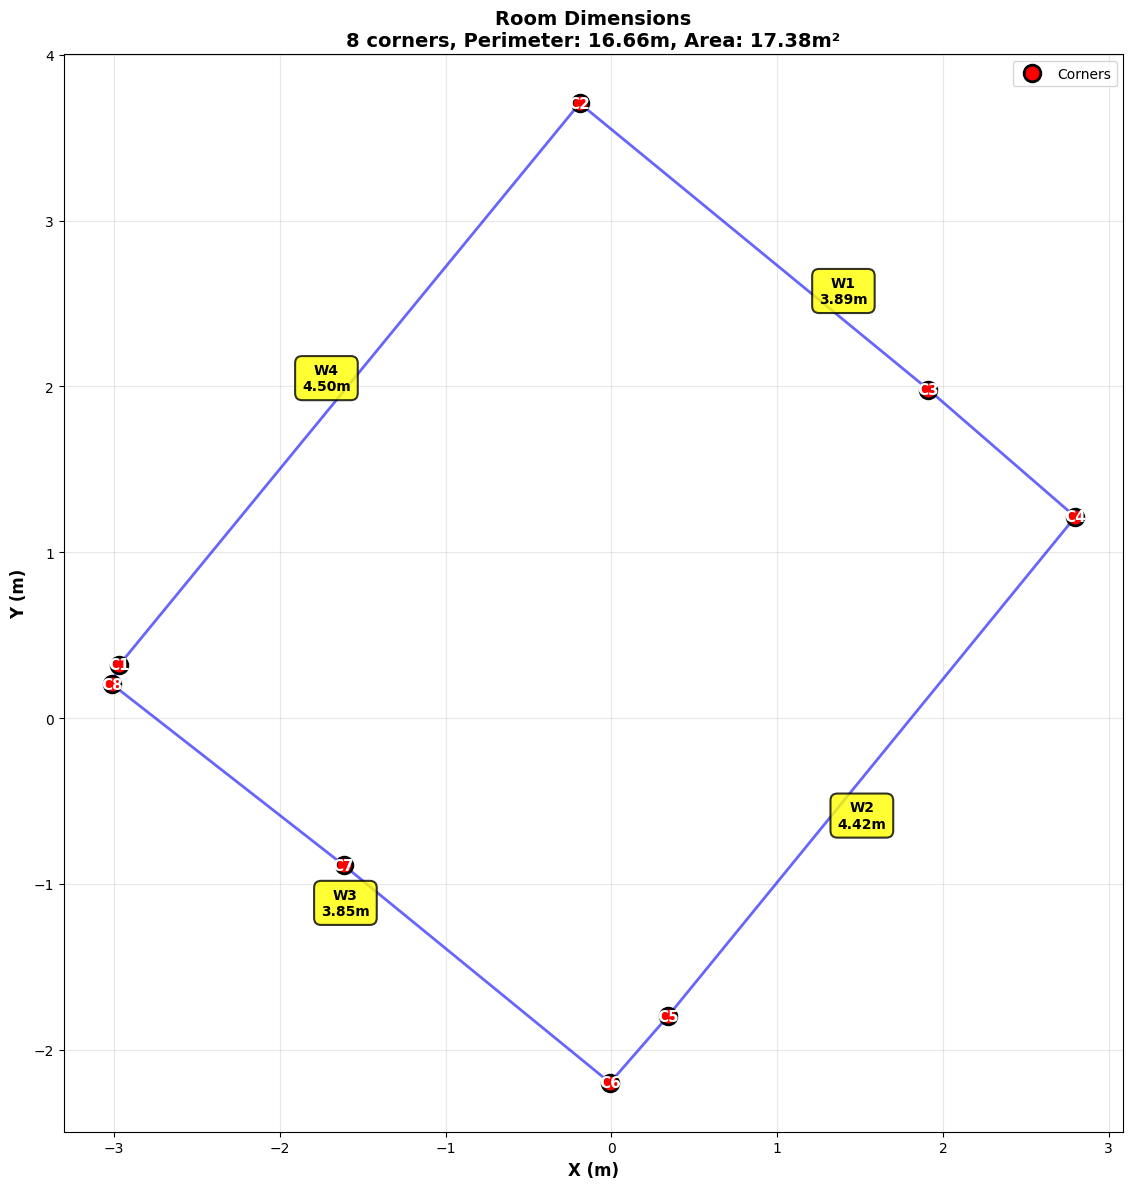

In [96]:
visualize_polygon_dimensions(Polygon(simplified_points), merged_dimensions)

In [113]:
def distribute_small_segments_fixed(dimensions, min_wall_length=0.25):
    """
    Distribute small wall segments equally (50/50) to adjacent walls
    
    Fixed: Handles circular ordering correctly
    
    Parameters:
    -----------
    dimensions : list of dict
        Wall dimensions
    min_wall_length : float
        Segments shorter than this are distributed (default 0.25m)
    
    Returns:
    --------
    new_dimensions : list of dict
        Adjusted dimensions with small segments distributed
    """
    
    print(f"\n{'='*70}")
    print(f"DISTRIBUTING SMALL SEGMENTS (50/50)")
    print(f"{'='*70}")
    print(f"Input walls: {len(dimensions)}")
    print(f"Min wall length: {min_wall_length}m")
    
    # Step 1: Identify all small segments
    small_indices = []
    for i, wall in enumerate(dimensions):
        if wall['length'] < min_wall_length:
            small_indices.append(i)
    
    if len(small_indices) == 0:
        print(f"No small segments found")
        return dimensions
    
    print(f"\nFound {len(small_indices)} small segment(s):")
    for idx in small_indices:
        wall = dimensions[idx]
        prev_idx = (idx - 1) % len(dimensions)
        next_idx = (idx + 1) % len(dimensions)
        
        print(f"  Wall {wall['wall_id']}: {wall['length']:.3f}m")
        print(f"    Prev wall {dimensions[prev_idx]['wall_id']}: {dimensions[prev_idx]['length']:.3f}m")
        print(f"    Next wall {dimensions[next_idx]['wall_id']}: {dimensions[next_idx]['length']:.3f}m")
    
    # Step 2: Calculate new corner positions for each small segment
    new_corners = {}  # Maps small segment index to new corner position
    
    for idx in small_indices:
        wall = dimensions[idx]
        
        # 50/50 split point along the small segment
        midpoint = (wall['start_point'] + wall['end_point']) / 2
        new_corners[idx] = midpoint
        
        amount_each = wall['length'] / 2
        
        prev_idx = (idx - 1) % len(dimensions)
        next_idx = (idx + 1) % len(dimensions)
        
        print(f"\n  Distributing Wall {wall['wall_id']} ({wall['length']:.3f}m):")
        print(f"    To prev wall {dimensions[prev_idx]['wall_id']}: {amount_each:.3f}m (50.0%)")
        print(f"    To next wall {dimensions[next_idx]['wall_id']}: {amount_each:.3f}m (50.0%)")
    
    # Step 3: Build new dimensions list
    new_dimensions = []
    
    for i, wall in enumerate(dimensions):
        # Skip small segments
        if i in small_indices:
            continue
        
        # Copy wall
        new_wall = wall.copy()
        
        # Check if previous wall was small - adjust start point
        prev_idx = (i - 1) % len(dimensions)
        if prev_idx in small_indices:
            new_wall['start_point'] = new_corners[prev_idx]
        
        # Check if next wall is small - adjust end point
        next_idx = (i + 1) % len(dimensions)
        if next_idx in small_indices:
            new_wall['end_point'] = new_corners[next_idx]
        
        # Recalculate length and angle
        vec = new_wall['end_point'] - new_wall['start_point']
        old_length = new_wall['length']
        new_wall['length'] = np.linalg.norm(vec)
        new_wall['angle'] = np.degrees(np.arctan2(vec[1], vec[0])) % 360
        
        # Report change
        if abs(new_wall['length'] - old_length) > 0.001:
            change = new_wall['length'] - old_length
            print(f"    Wall {wall['wall_id']}: {old_length:.3f}m → {new_wall['length']:.3f}m "
                  f"({change:+.3f}m)")
        
        new_dimensions.append(new_wall)
    
    # Step 4: Renumber walls
    for idx, wall in enumerate(new_dimensions, 1):
        wall['wall_id'] = idx
        wall['corner_start'] = idx
        wall['corner_end'] = (idx % len(new_dimensions)) + 1
    
    print(f"\n✓ Result: {len(dimensions)} → {len(new_dimensions)} walls")
    
    return new_dimensions


def merge_with_distribution(dimensions,
                            angle_tolerance=5.0,
                            max_gap=0.15,
                            min_wall_length=0.25,
                            max_iterations=5):
    """
    Complete merging pipeline with small segment distribution
    
    Integrates with your existing merge_collinear_walls and merge_short_walls
    
    Pipeline:
    1. Distribute small segments to neighbors (NEW!)
    2. Merge collinear walls
    3. Check for new small segments
    4. Repeat until convergence
    """
    
    print(f"\n{'='*70}")
    print(f"WALL MERGING WITH DISTRIBUTION")
    print(f"{'='*70}")
    print(f"Initial walls: {len(dimensions)}")
    
    current = dimensions
    
    for iteration in range(max_iterations):
        print(f"\n{'-'*70}")
        print(f"ITERATION {iteration + 1}")
        print(f"{'-'*70}")
        
        prev_count = len(current)
        
        # Step 1: Distribute small segments (NEW STEP!)
        current = distribute_small_segments_fixed(
            current,
            min_wall_length=min_wall_length
        )
        
        # Step 2: Merge collinear walls (your existing function)
        current = merge_collinear_walls(
            current,
            angle_tolerance=angle_tolerance,
            max_gap=max_gap
        )
        
        current_count = len(current)
        
        print(f"\nIteration {iteration + 1} result: {prev_count} → {current_count} walls")
        
        # Check convergence
        if current_count == prev_count:
            print(f"\n✓ Converged after {iteration + 1} iterations")
            break
    
    print(f"\n{'='*70}")
    print(f"FINAL RESULT")
    print(f"{'='*70}")
    print(f"Walls: {len(dimensions)} → {len(current)}")
    print(f"Reduction: {len(dimensions) - len(current)} walls ({100*(len(dimensions)-len(current))/len(dimensions):.1f}%)")
    
    return current

In [114]:
merged_dimensions = merge_with_distribution(
    dimensions,
    angle_tolerance=5.0,      # Merge walls within 5° of collinear
    max_gap=0.15,             # Allow 15cm gaps
    min_wall_length=0.25,     # Distribute segments < 25cm
    max_iterations=5
)


WALL MERGING WITH DISTRIBUTION
Initial walls: 8

----------------------------------------------------------------------
ITERATION 1
----------------------------------------------------------------------

DISTRIBUTING SMALL SEGMENTS (50/50)
Input walls: 8
Min wall length: 0.25m

Found 1 small segment(s):
  Wall 5: 0.124m
    Prev wall 7: 1.772m
    Next wall 1: 4.380m

  Distributing Wall 5 (0.124m):
    To prev wall 7: 0.062m (50.0%)
    To next wall 1: 0.062m (50.0%)
    Wall 1: 4.380m → 4.439m (+0.059m)
    Wall 7: 1.772m → 1.792m (+0.019m)

✓ Result: 8 → 7 walls

MERGING COLLINEAR WALLS
Input walls: 7
Angle tolerance: 5.0°
Max gap: 0.15m
  Merged 2 walls (indices 1-2): 3.89m → 3.89m
  Merged 2 walls (indices 3-4): 4.42m → 4.42m
  Merged 2 walls (indices 5-6): 3.87m → 3.87m

✓ Result: 7 → 4 walls

Iteration 1 result: 8 → 4 walls

----------------------------------------------------------------------
ITERATION 2
----------------------------------------------------------------------



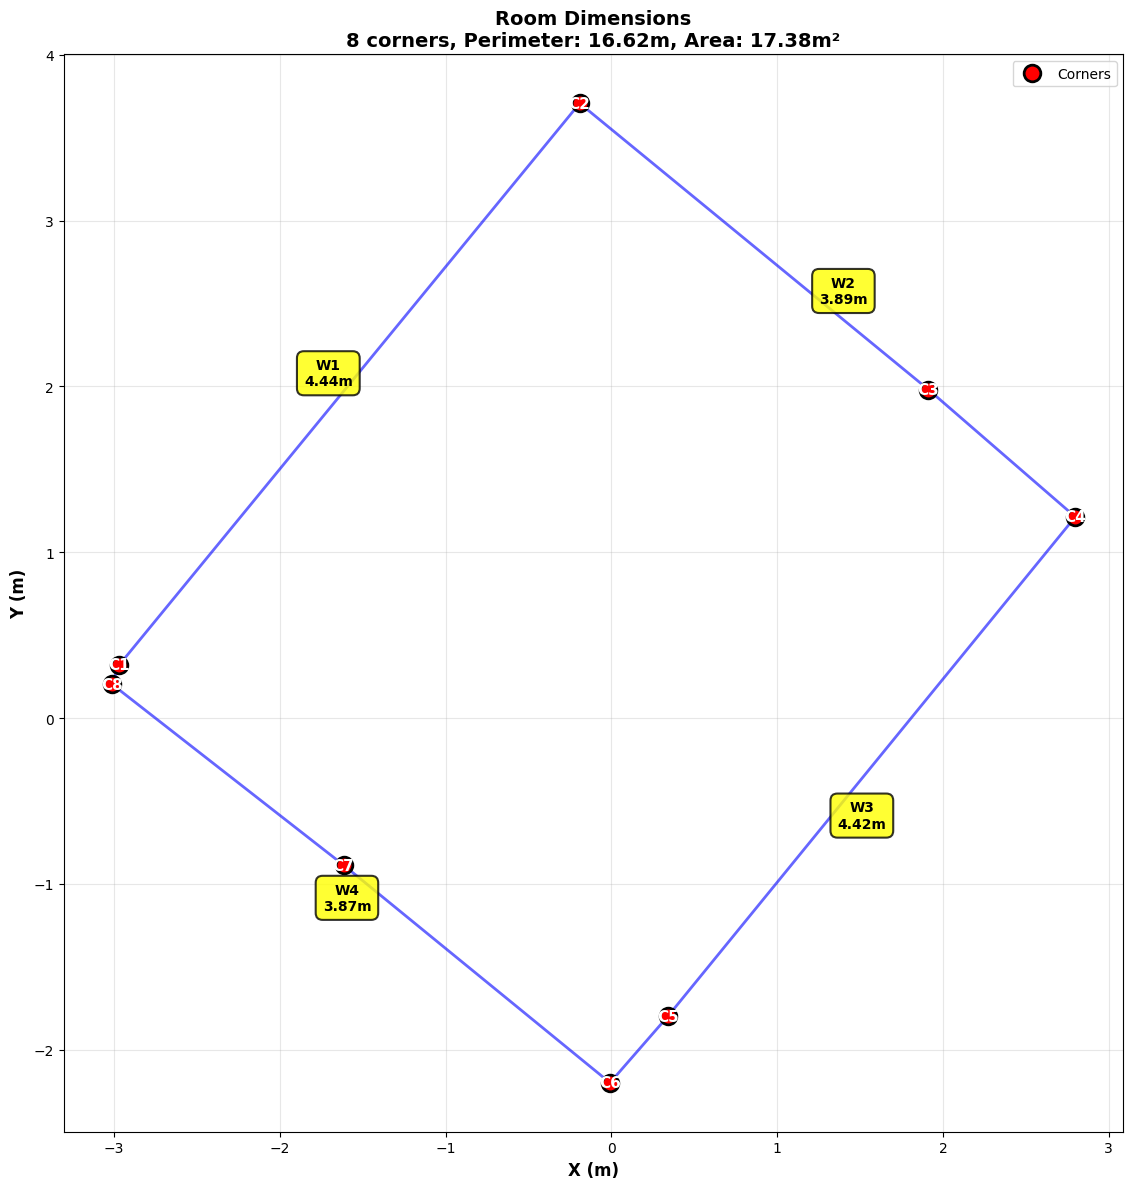

In [115]:
visualize_polygon_dimensions(Polygon(simplified_points), merged_dimensions)

In [196]:
def extract_accurate_floorplan(wall_points, 
                               concave_ratio=0.05,
                               offset_distance=None,
                               merge_angle_tol=8.0,
                               merge_gap=0.15,
                               min_wall_length=0.30):
    """
    Optimized pipeline for accurate floorplan extraction
    NO simplification - just merging
    """
    
    # Step 1: Concave hull
    from shapely.geometry import MultiPoint
    import shapely
    
    multi_point = MultiPoint(wall_points[:, :2])
    boundary = shapely.concave_hull(multi_point, ratio=concave_ratio)
    
    # Step 2: Optional offset (if you computed wall thickness)
    if offset_distance:
        boundary = boundary.buffer(-offset_distance)
    
    # Step 3: Extract polygon points
    polygon_points = np.array(boundary.exterior.coords)[:-1]
    
    print(f"Boundary vertices: {len(polygon_points)}")
    
    # Step 4: Get initial dimensions
    dimensions = compute_polygon_dimensions(polygon_points)
    
    # Step 5: Merge (NO SIMPLIFICATION!)
    merged = merge_walls_complete(
        dimensions,
        angle_tolerance=merge_angle_tol,
        max_gap=merge_gap,
        min_wall_length=min_wall_length
    )
    
    return merged

In [201]:
final_walls = extract_accurate_floorplan(
    all_wall_points,
    concave_ratio=0.05,
    offset_distance=None
    merge_angle_tol=8.0,
    merge_gap=0.15,
    min_wall_length=0.30
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (646013276.py, line 4)

In [202]:
final_walls

[{'wall_id': 1,
  'start_point': array([-2.29901884, -0.90718542]),
  'end_point': array([0.5944672 , 2.25673579]),
  'length': np.float64(4.287500312248962),
  'angle': np.float64(47.55629362468778),
  'merged_from': [0, 1, 2],
  'num_segments': 3},
 {'wall_id': 2,
  'start_point': array([0.5944672 , 2.25673579]),
  'end_point': array([1.15673062, 1.97342183]),
  'length': np.float64(0.6296085675619869),
  'angle': np.float64(333.25732442882804)},
 {'wall_id': 3,
  'start_point': array([1.15673062, 1.97342183]),
  'end_point': array([1.41336144, 2.22209307]),
  'length': np.float64(0.3573468330965674),
  'angle': np.float64(44.097543625747484)},
 {'wall_id': 4,
  'start_point': array([1.41336144, 2.22209307]),
  'end_point': array([2.15330142, 1.55253048]),
  'length': np.float64(0.9979104347267863),
  'angle': np.float64(317.85844245250485)},
 {'wall_id': 5,
  'start_point': array([2.15330142, 1.55253048]),
  'end_point': array([1.77863717, 1.18636316]),
  'length': np.float64(0.5238

In [203]:
def extract_merged_wall_polygon(merged_walls):
    """
    Extract polygon with only merged wall endpoints
    (Removes intermediate vertices but keeps real corners)
    
    Returns:
    --------
    corner_points : np.ndarray (N, 2)
        Just the corners (merged wall endpoints)
    """
    
    # Collect unique corners
    corners = []
    
    for wall in merged_walls:
        corners.append(wall['start_point'])
    
    # Close polygon (last wall's end = first wall's start)
    corners = np.array(corners)
    
    print(f"\nExtracted {len(corners)} corners from {len(merged_walls)} walls")
    
    return corners


def visualize_final_dimensions(merged_walls):
    """
    Clean visualization of final wall dimensions
    """
    import matplotlib.pyplot as plt
    
    # Extract corners
    corners = extract_merged_wall_polygon(merged_walls)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Draw polygon
    poly_closed = np.vstack([corners, corners[0]])
    ax.plot(poly_closed[:, 0], poly_closed[:, 1],
            'b-', linewidth=2, alpha=0.6)
    
    # Mark corners
    for i, corner in enumerate(corners):
        ax.plot(corner[0], corner[1], 'go', markersize=15,
                markeredgecolor='black', markeredgewidth=2)
        ax.text(corner[0], corner[1], f"C{i+1}",
                fontsize=11, fontweight='bold',
                ha='center', va='center', color='white')
    
    # Label walls with dimensions
    colors = plt.cm.tab10(np.linspace(0, 1, len(merged_walls)))
    
    for i, wall in enumerate(merged_walls):
        # Draw wall line (thick)
        ax.plot([wall['start_point'][0], wall['end_point'][0]],
                [wall['start_point'][1], wall['end_point'][1]],
                '-', color=colors[i], linewidth=6, alpha=0.7)
        
        # Dimension label
        mid_x = (wall['start_point'][0] + wall['end_point'][0]) / 2
        mid_y = (wall['start_point'][1] + wall['end_point'][1]) / 2
        
        # Offset perpendicular
        vec = wall['end_point'] - wall['start_point']
        length = np.linalg.norm(vec)
        if length > 0:
            vec_norm = vec / length
            perp = np.array([-vec_norm[1], vec_norm[0]])
            offset = 0.20  # 20cm
            label_x = mid_x + perp[0] * offset
            label_y = mid_y + perp[1] * offset
        else:
            label_x, label_y = mid_x, mid_y
        
        ax.text(label_x, label_y,
                f"W{wall['wall_id']}\n{wall['length']:.2f}m",
                fontsize=12, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.6',
                         facecolor='yellow', alpha=0.95,
                         edgecolor='black', linewidth=2))
    
    # Summary
    total_perim = sum(w['length'] for w in merged_walls)
    area = Polygon(corners).area
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=13, fontweight='bold')
    ax.set_title(f'Final Room Dimensions\n'
                f'{len(corners)} corners, {len(merged_walls)} walls\n'
                f'Perimeter: {total_perim:.2f}m, Area: {area:.2f}m²',
                fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


Extracted 11 corners from 11 walls


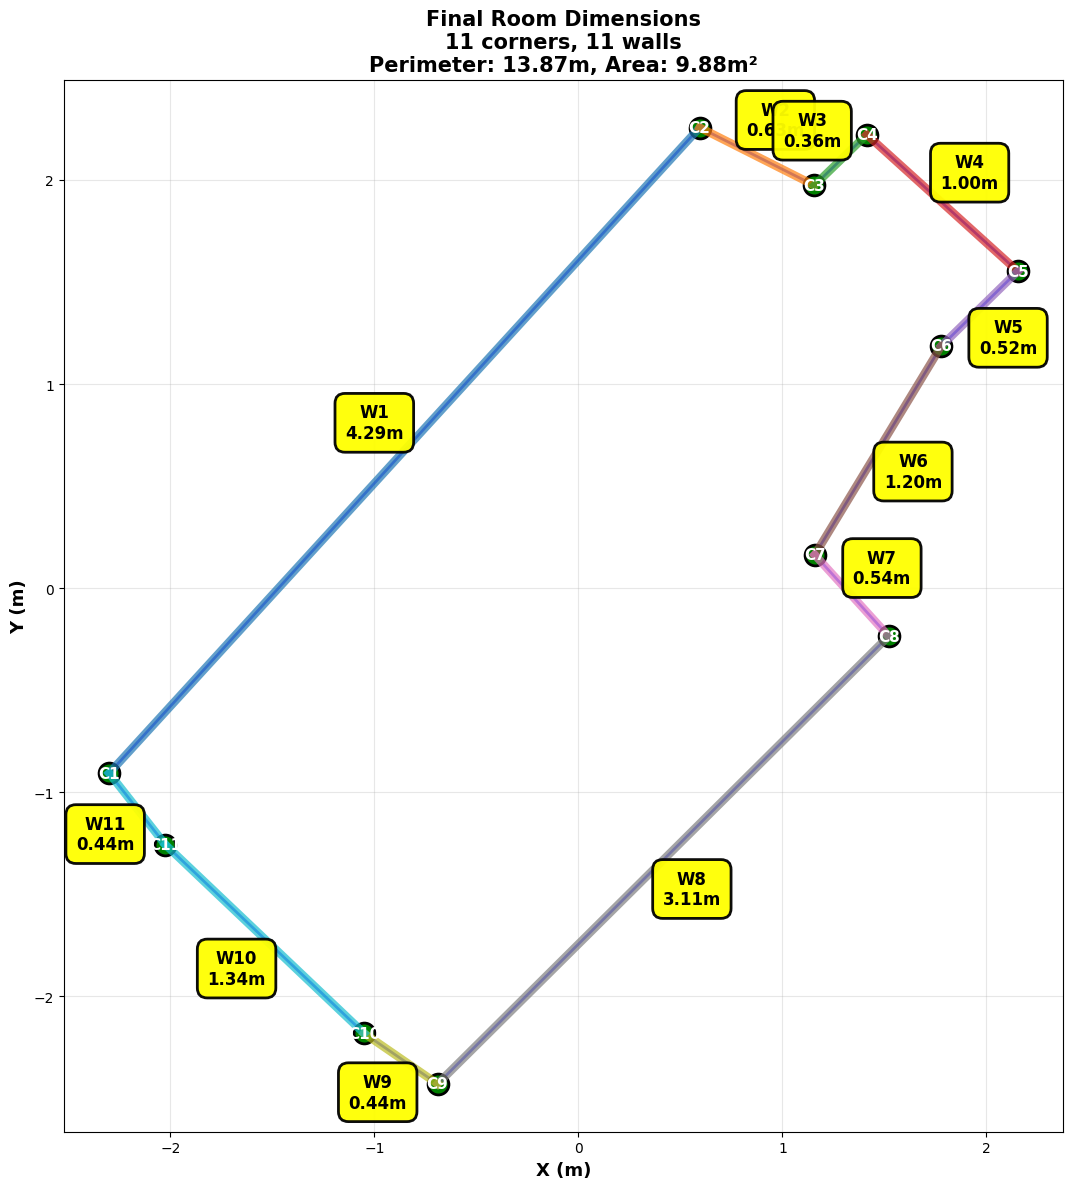

In [204]:
visualize_final_dimensions(final_walls)

In [74]:
import alphashape

In [75]:
def compute_concave_hull(points_2d, alpha=0.5):
    """
    Compute concave hull (alpha shape) of 2D points
    
    Args:
        points_2d: Nx2 numpy array of 2D points
        alpha: Alpha parameter controlling hull tightness
               - Smaller alpha (0.1-0.3): Tighter, more detailed hull (follows contours closely)
               - Medium alpha (0.5-0.8): Balanced
               - Larger alpha (1.0-2.0): Looser, more convex (smooths over gaps)
               - alpha → infinity: Becomes convex hull
    
    Returns:
        hull_polygon: Shapely Polygon object, or None if failed
    """
    
    print(f"\nComputing concave hull with alpha={alpha}...")
    print(f"Input: {len(points_2d)} points")
    
    try:
        # Compute alpha shape
        hull = alphashape.alphashape(points_2d, alpha)
        
        # Check result type
        if hull is None or hull.is_empty:
            print("Warning: Hull computation returned empty result")
            return None
        
        # Handle MultiPolygon (disconnected regions)
        if hull.geom_type == 'MultiPolygon':
            print(f"Warning: Got MultiPolygon with {len(list(hull.geoms))} parts")
            # Take the largest polygon
            polygons = list(hull.geoms)
            hull = max(polygons, key=lambda p: p.area)
            print(f"Selected largest polygon (area={hull.area:.2f} m²)")
        
        # Get hull info
        num_vertices = len(hull.exterior.coords) - 1  # -1 because first=last
        
        print(f"✓ Hull computed successfully")
        print(f"  Vertices: {num_vertices}")
        print(f"  Area: {hull.area:.2f} m²")
        print(f"  Perimeter: {hull.length:.2f} m")
        
        return hull
    
    except Exception as e:
        print(f"Error computing hull: {e}")
        return None

In [77]:
hull = compute_concave_hull(wall_points_2d)


Computing concave hull with alpha=0.5...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 149
  Area: 12.33 m²
  Perimeter: 14.11 m


In [78]:
def visualize_hull(points_2d, hull_polygon, title="Concave Hull", downsample=10):
    """
    Visualize 2D points with hull overlay
    
    Args:
        points_2d: Nx2 numpy array of original points
        hull_polygon: Shapely Polygon from compute_concave_hull
        title: Plot title
        downsample: Downsample points for faster plotting
    """
    if hull_polygon is None:
        print("No hull to visualize")
        return
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    # Extract hull vertices
    hull_coords = np.array(hull_polygon.exterior.coords)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot points
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
               s=1, c='lightblue', alpha=0.3, label='Wall points')
    
    # Plot hull
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'r-', linewidth=2, label='Concave hull')
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'ro', markersize=4, label='Hull vertices')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization info:")
    print(f"  Plotted {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    print(f"  Hull has {len(hull_coords)-1} vertices")

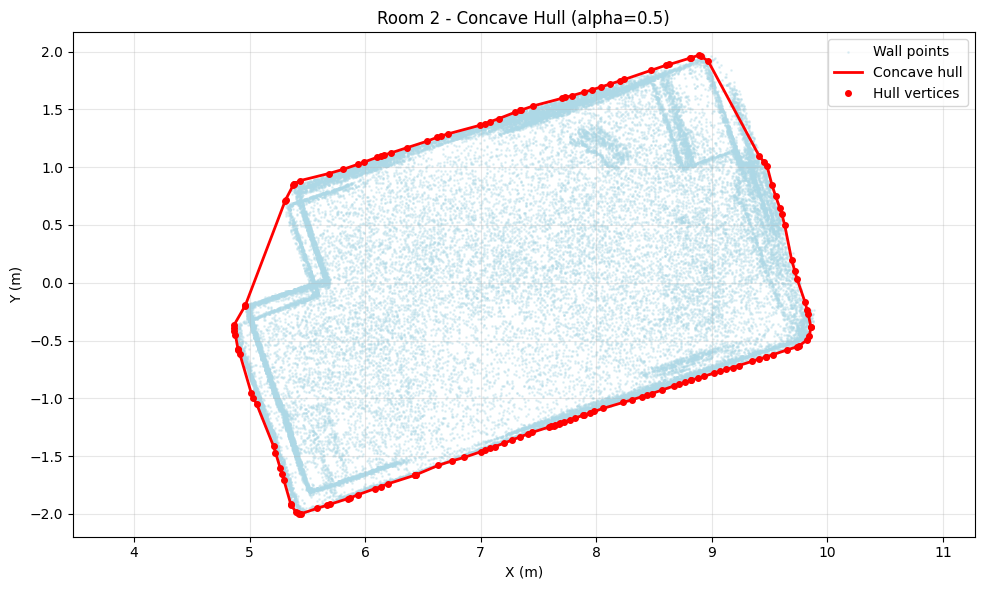


Visualization info:
  Plotted 42699 points (downsampled from 426989)
  Hull has 149 vertices


In [79]:
visualize_hull(points_2d, hull, title="Room 2 - Concave Hull (alpha=0.5)")

In [80]:
def compare_alpha_values(points_2d, alpha_values=[0.3, 0.5, 0.8, 1.0], downsample=10):
    """
    Compare different alpha values side-by-side
    
    Args:
        points_2d: Nx2 numpy array
        alpha_values: List of alpha values to test
        downsample: Downsample for plotting
    """
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    num_alphas = len(alpha_values)
    fig, axes = plt.subplots(1, num_alphas, figsize=(6*num_alphas, 6))
    
    if num_alphas == 1:
        axes = [axes]
    
    for i, alpha in enumerate(alpha_values):
        ax = axes[i]
        
        # Compute hull
        hull = compute_concave_hull(points_2d, alpha=alpha)
        
        if hull is not None:
            # Plot points
            ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                      s=1, c='lightblue', alpha=0.3)
            
            # Plot hull
            hull_coords = np.array(hull.exterior.coords)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'r-', linewidth=2)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'ro', markersize=3)
            
            ax.set_title(f'Alpha = {alpha}\n{len(hull_coords)-1} vertices, '
                        f'Area = {hull.area:.2f} m²')
        else:
            ax.set_title(f'Alpha = {alpha}\n(failed)')
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Computing concave hull with alpha=0.05...
Input: 122367 points
✓ Hull computed successfully
  Vertices: 51
  Area: 12.42 m²
  Perimeter: 14.10 m


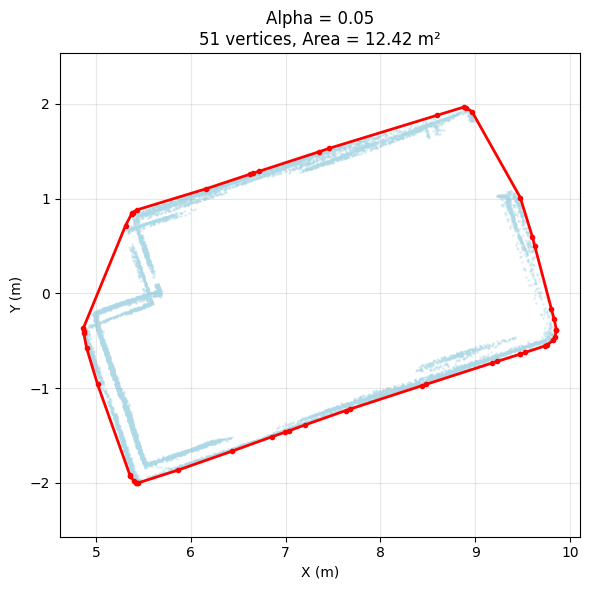

In [83]:
compare_alpha_values(wall_points_2d, alpha_values=[0.05])

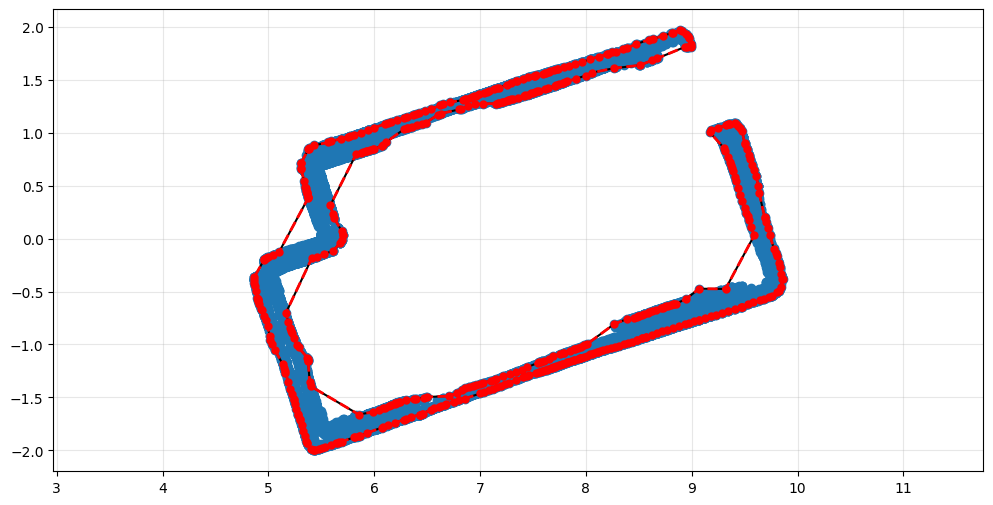

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

# Get alpha shape
alpha_hull = alpha_shape(wall_points_2d, alpha=0.4)

if alpha_hull.geom_type == 'Polygon':
    x, y = alpha_hull.exterior.xy
    coords = np.array(list(zip(x, y)))
    
    # Plot edges
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    
    # Plot vertices
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [84]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [85]:
voxel_down_pcd = sem_seg.pcd

In [ ]:
(voxel_down_pcd.select_by_index(ind))

PointCloud with 410042 points.

In [91]:
cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)

Showing outliers (red) and inliers (gray): 


In [94]:
o3d.visualization.draw_geometries([cl])

### pointnet

In [16]:
predictions = sem_seg.pointnet_segmentation(sem_seg.points, type='all')

In [17]:
sem_seg.visualize_segments(predictions)

PointCloud with 891428 points.

In [20]:
sem_seg.classes["ceiling"]

0

In [21]:
ceiling_mask = predictions == sem_seg.classes["ceiling"]
wall_mask = predictions == sem_seg.classes["wall"]
door_mask = predictions == sem_seg.classes["door"]
window_mask = predictions == sem_seg.classes["window"]

ceiling_points_2d = points_2d[ceiling_mask]
wall_points_2d = points_2d[wall_mask]
door_points_2d = points_2d[door_mask]
window_points_2d = points_2d[window_mask]

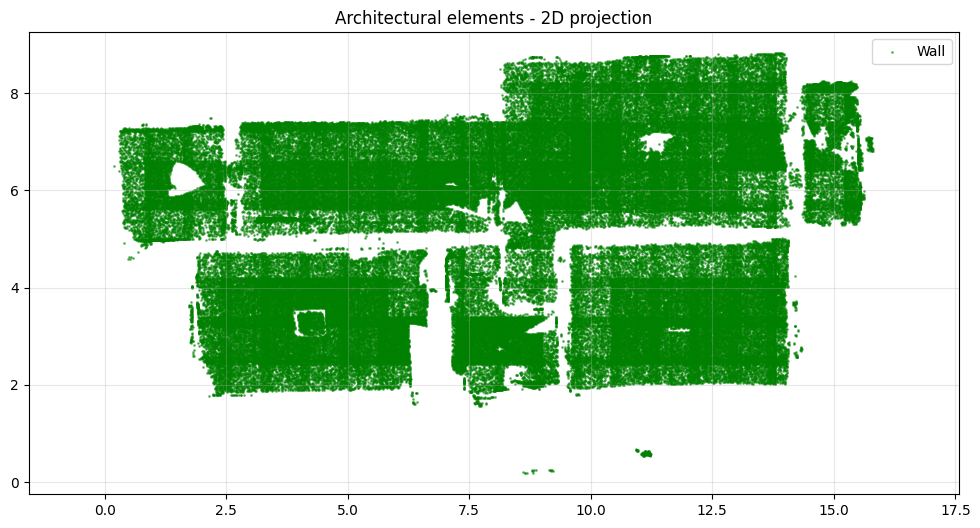

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Wall', alpha=0.5)
# plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [116]:
clustering = DBSCAN(eps=0.1, min_samples=5, n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [121]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 16


In [122]:
ceiling_clusters

array([0, 0, 0, ..., 1, 1, 1], shape=(124351,))

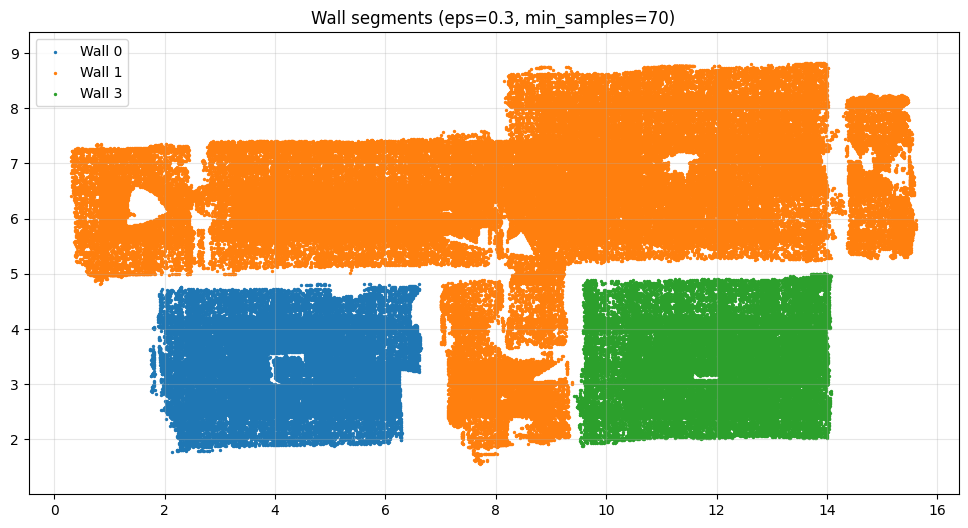

In [133]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 300:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()
plt.title(f'Wall segments (eps=0.3, min_samples=70)')
plt.grid(True, alpha=0.3)
plt.show()

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

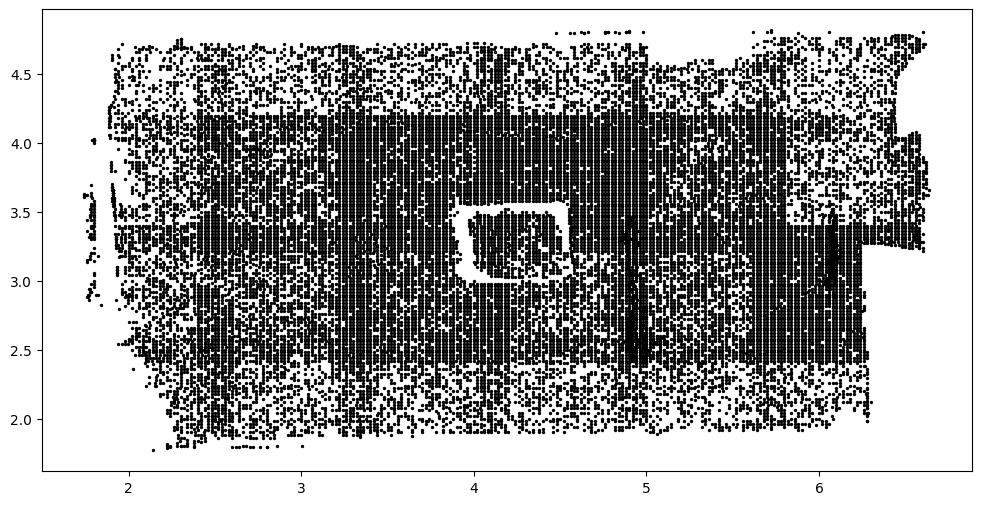

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [131]:
sum(mask)

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


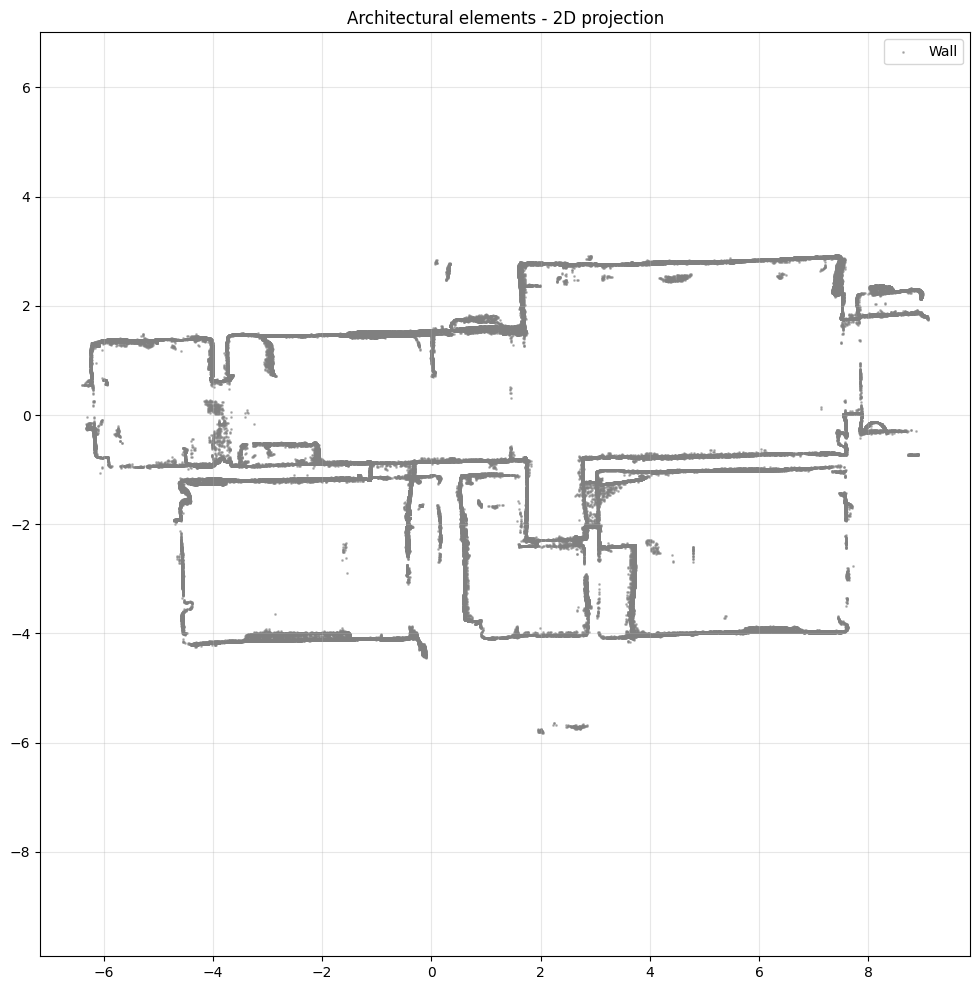

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

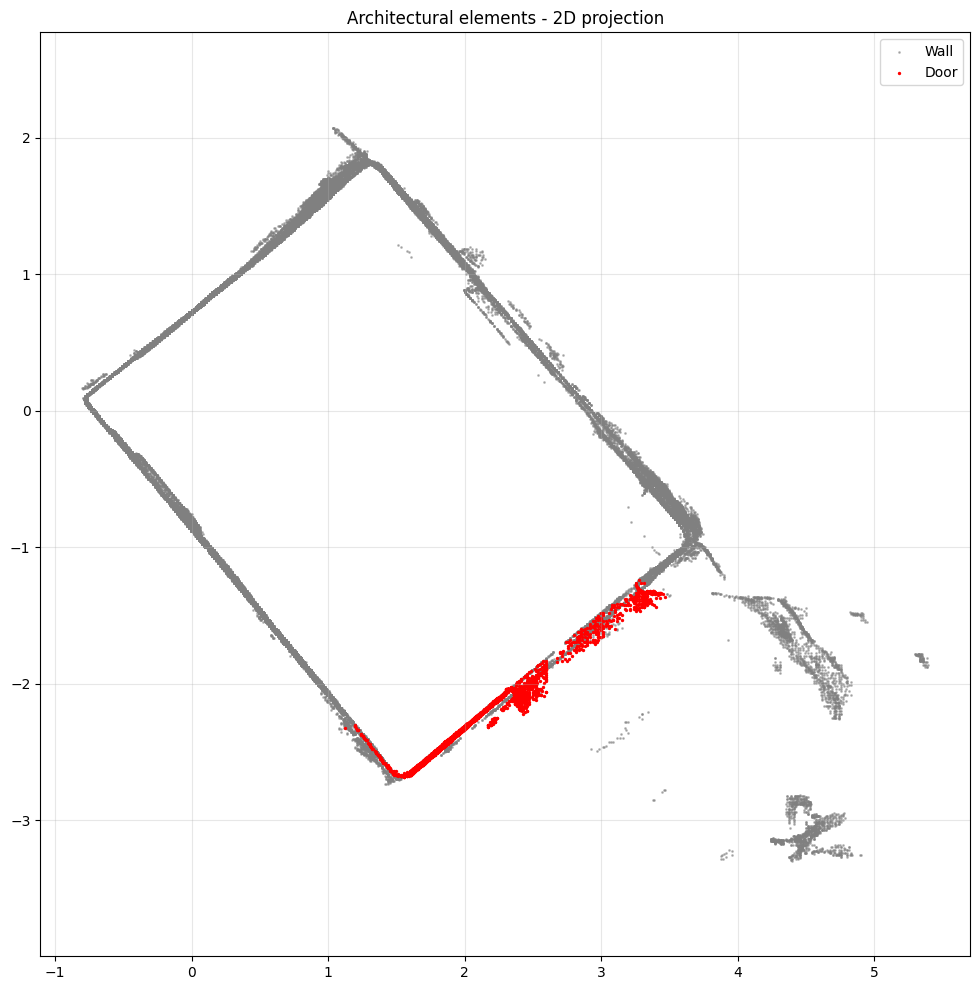

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()